# SED fitting with PROSPECTOR
Based on https://prospect.readthedocs.io/en/latest/quickstart.html

## Import modules and environment variables
This is a notebook that allows you to do SED fitting using known photometry (i.e. obtained via HOSTPHOT)
Assumes that you already have installed Prospector and its dependencies. If you have issues with that, please contact me.

Important: Set the 'HOME_SPS' variable to your fsps instalation

In [2]:
import os
os.environ['SPS_HOME'] = '/home/goio/fsps/'

In [3]:
from pathlib import Path
import fsps
import dynesty
import sedpy
import h5py, astropy
import numpy as np
import astroquery
from prospect.utils.obsutils import fix_obs
import sedpy
from sedpy.observate import list_available_filters
from astropy.coordinates import SkyCoord
import astropy.wcs as wcs
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from prospect.models.templates import TemplateLibrary
from prospect.models import SpecModel
import prospect.models
from prospect.models import priors
from prospect.sources import CSPSpecBasis
from prospect.sources import FastStepBasis
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
from prospect.fitting import fit_model
from prospect.models import PolySpecModel
import prospect.models
from prospect.fitting import lnprobfn, fit_model


## We import the filters and the photometry
First of all we define the filters in different bands for which we have photometry available to compute the SED, obtained by HOSTPHOT.
PROSPECTOR has already built in a lot of filters (using the package sedpy). 
Since PS1 filters are not predefined (we can't load them automatically) we will have to add them manually, using the .par files. 

In [3]:
from sedpy import observate
import itertools

surveys = {'PS1':['g','r','i','z','y'], '2MASS':['J','H','Ks'], 'unWISE':['W1','W2','W3','W4'], 'SDSS':['u','g','r','i','z'], 'DES':['Y','g','r','i','z'], 'GALEX':['FUV','NUV']}
PS1_filt=[]
for filt in ['g','r','i','z','y']:
    PS1 = observate.Filter("PS1_"+filt, directory="/home/goio/analisis/filterpars/")
    PS1_filt.append(PS1)
    
twomass_filt = ['twomass_'+filt for filt in ['J','H','Ks']]
wise_filt = ['wise_w'+filt for filt in ['1','2','3','4']]
sdss_filt = ['sdss_'+filt+'0' for filt in ['u','g','r','i','z']]
DES_filt=['decam_'+filt for filt in ['Y','g','r','i','z']]
galex_filt= ['galex_'+filt for filt in ['FUV','NUV']]

twomass_filt+=wise_filt+sdss_filt+DES_filt+galex_filt
#print('The list of defined filters are', filters)

def_filt=observate.load_filters(twomass_filt)

PS1_filt+=def_filt

In [4]:
target='2001az'
#The apperture in case of local analaysis. In case of global this value should be suppresed.
ap=str(1)
#We find the files ending in local, since we are interested on doing that analysis. Otherwise switch to global.
analysis='local'

In [7]:
import os
import pandas as pd
import re


counter = itertools.count(0)
filters_dict = {survey:{filt:PS1_filt[next(counter)] for filt in surveys[survey]} for survey in surveys}

print(filters_dict)

path = Path('images') / target

survey_pattern = f"{analysis}_phot_(.+)\.csv"

files=[f for f in sorted(os.listdir(path)) if f.startswith(analysis)]
print('The existing HOSTPHOT photometry files for the target' ,target,  'are',str(files))
#We obtain the redshift. In case of the global analysis, we will use the local files to get the redshift.

filters_list = []
mags_and_errors = ([], [])

z_obs = pd.read_csv(path / files[0], index_col=False)['zspec'].item()

invalid_items = [np.inf, -np.inf]
for fname in files:
    survey = re.match(survey_pattern, fname).group(1)
    print(survey)
    df = pd.read_csv(path / fname, index_col=False)
    display(df)
    for band in surveys[survey]:
        if survey == 'SDSS' and band != 'u':
            continue
        if survey == 'PS1' and filters_dict['DES']['Y' if band == 'y' else band] in filters_list:  # We use the fact that DES is always loaded first
            continue
        
        if analysis=='local':
            key = band+ap
        else:
            key = band
        print(df[key].item())
        if (mag := df[key].item()) not in invalid_items and not np.isnan(mag):
            print("acc")
            mags_and_errors[0].append(mag)
            filters_list.append(filters_dict[survey][band])
        else:
            continue
        if np.isnan(err := df[key + '_err'].item()):
            err = 0
        mags_and_errors[1].append(err)
                
#Now you have float values of the u filter and arrays corresponding to the magnituds and errors per each band.
#IMPORTANT! The order matters, depending on the index of the array you have certain filter!
#Then you can just append this values into one array, (mAB and eMAB) by the same order that you import the filters
print('')

print(filters_list)
print(len(filters_list))
print(mags_and_errors)
print(len(mags_and_errors[0]))
    

{'PS1': {'g': <class 'sedpy.observate.Filter'>(PS1_g), 'r': <class 'sedpy.observate.Filter'>(PS1_r), 'i': <class 'sedpy.observate.Filter'>(PS1_i), 'z': <class 'sedpy.observate.Filter'>(PS1_z), 'y': <class 'sedpy.observate.Filter'>(PS1_y)}, '2MASS': {'J': <class 'sedpy.observate.Filter'>(twomass_J), 'H': <class 'sedpy.observate.Filter'>(twomass_H), 'Ks': <class 'sedpy.observate.Filter'>(twomass_Ks)}, 'unWISE': {'W1': <class 'sedpy.observate.Filter'>(wise_w1), 'W2': <class 'sedpy.observate.Filter'>(wise_w2), 'W3': <class 'sedpy.observate.Filter'>(wise_w3), 'W4': <class 'sedpy.observate.Filter'>(wise_w4)}, 'SDSS': {'u': <class 'sedpy.observate.Filter'>(sdss_u0), 'g': <class 'sedpy.observate.Filter'>(sdss_g0), 'r': <class 'sedpy.observate.Filter'>(sdss_r0), 'i': <class 'sedpy.observate.Filter'>(sdss_i0), 'z': <class 'sedpy.observate.Filter'>(sdss_z0)}, 'DES': {'Y': <class 'sedpy.observate.Filter'>(decam_Y), 'g': <class 'sedpy.observate.Filter'>(decam_g), 'r': <class 'sedpy.observate.Filter

,J1,H1,Ks1,J1_err,H1_err,Ks1_err,J2,H2,Ks2,J2_err,...,J4,H4,Ks4,J4_err,H4_err,Ks4_err,name,ra,dec,zspec
0,18.39674,17.465757,16.571554,0.973577,1.047502,0.747332,16.753957,16.045478,15.24745,0.429517,...,14.816275,14.228787,13.618813,0.145108,0.214098,0.198426,2001az,248.614487,76.029541,0.04059


18.3967395904187
acc
17.46575730864536
acc
16.57155410288455
acc
DES


,g1,r1,i1,z1,Y1,g1_err,r1_err,i1_err,z1_err,Y1_err,...,Y4,g4_err,r4_err,i4_err,z4_err,Y4_err,name,ra,dec,zspec
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2001az,248.614487,76.029541,0.04059


nan
nan
nan
nan
nan
GALEX


,FUV1,NUV1,FUV1_err,NUV1_err,FUV2,NUV2,FUV2_err,NUV2_err,FUV3,NUV3,FUV3_err,NUV3_err,FUV4,NUV4,FUV4_err,NUV4_err,name,ra,dec,zspec
0,22.57546,NaN,0.667521,NaN,20.954834,NaN,0.329857,NaN,19.806052,NaN,0.200374,NaN,19.058955,NaN,0.147297,NaN,2001az,248.614487,76.029541,0.04059


22.575460223464933
acc
nan
PS1


,g1,r1,i1,z1,y1,g1_err,r1_err,i1_err,z1_err,y1_err,...,y4,g4_err,r4_err,i4_err,z4_err,y4_err,name,ra,dec,zspec
0,20.548895,19.945144,19.655868,19.399254,19.229001,0.060986,0.033296,0.021081,0.031173,0.042795,...,15.805384,0.018994,0.015139,0.015228,0.015775,0.019186,2001az,248.614487,76.029541,0.04059


20.548894662057634
acc
19.945144362406307
acc
19.655868426310835
acc
19.399254477881406
acc
19.22900149919584
acc
SDSS


,u1,g1,r1,i1,z1,u1_err,g1_err,r1_err,i1_err,z1_err,...,z4,u4_err,g4_err,r4_err,i4_err,z4_err,name,ra,dec,zspec
0,22.167266,20.465201,19.82817,19.462151,19.159362,3.343147,0.926422,0.393541,0.364809,0.271252,...,15.82215,0.366737,0.129022,0.080682,0.064427,0.057263,2001az,248.614487,76.029541,0.04059


22.16726608670475
acc
unWISE


,W11,W21,W31,W41,W11_err,W21_err,W31_err,W41_err,W12,W22,...,W34,W44,W14_err,W24_err,W34_err,W44_err,name,ra,dec,zspec
0,17.147086,17.057366,14.25638,12.377656,0.181347,0.199409,0.220767,0.669071,15.63497,15.539728,...,11.09329,9.482637,0.147642,0.161066,0.176512,0.726759,2001az,248.614487,76.029541,0.04059


17.147086047815105
acc
17.057366200272426
acc
14.256380088446203
acc
12.377655773368204
acc

[<class 'sedpy.observate.Filter'>(twomass_J), <class 'sedpy.observate.Filter'>(twomass_H), <class 'sedpy.observate.Filter'>(twomass_Ks), <class 'sedpy.observate.Filter'>(galex_FUV), <class 'sedpy.observate.Filter'>(PS1_g), <class 'sedpy.observate.Filter'>(PS1_r), <class 'sedpy.observate.Filter'>(PS1_i), <class 'sedpy.observate.Filter'>(PS1_z), <class 'sedpy.observate.Filter'>(PS1_y), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(wise_w2), <class 'sedpy.observate.Filter'>(wise_w3), <class 'sedpy.observate.Filter'>(wise_w4)]
14
([18.3967395904187, 17.46575730864536, 16.57155410288455, 22.575460223464933, 20.548894662057634, 19.945144362406307, 19.655868426310835, 19.399254477881406, 19.22900149919584, 22.16726608670475, 17.147086047815105, 17.057366200272426, 14.256380088446203, 12.377655773368204], [0.973576931288386, 1.047

## We generate the obs dictionary
The first step that you need to do to fit a SED with PROSPECTOR is to generate the 'obs' dictionary.
In this dictionary we will store our observables. In our case, it will be redshift, magnitudes and its uncertainties. All the observed AB magnitudes need to be transformed into maggies, so we perform the conversion and store it at the dictionary.

This observable dictionary also allows you to add flux values and its uncertainties, in case you want to fit a spectrum or spectrum+photometry. Since this is not the case, we fix the keys "wavelenght" and "spectrum" to None.

In [8]:
from prospect.utils.obsutils import fix_obs
obs={}
obs['filters']=filters_list
obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])


#Add the redshift value by hand or load it


obs['redshift']=z_obs

#Then we load the magnitudes using a .txt file or using an array.
#IMPORTANT: The input that we provide to the dictionary has to follow the same order
#as the list of filters.

m_AB=np.array(mags_and_errors[0])
e_mAB=np.array(mags_and_errors[1])


obs["maggies"] = 10**(-0.4*m_AB)

#print('The error magnitudes are', e_mAB)

e_mAB = np.clip(e_mAB, 0.05, np.inf) #It is strongly recommended to add a floor error
obs["maggies_unc"]=e_mAB*10**(-0.4*m_AB)/1.086

#Since we are not trying to fit from input spectra the obs dictionary inputs related to that input should be None

obs["wavelength"] = None
obs["spectrum"] = None
obs['unc']=None
obs['mask']=None
obs=fix_obs(obs)

## We plot the observables 
We plot the observed photometry including uncertainties to check that everything is consistent in PROSPECTOR input units (maggies).

Text(0.5, 0, '$\\lambda$ (\\AA)')

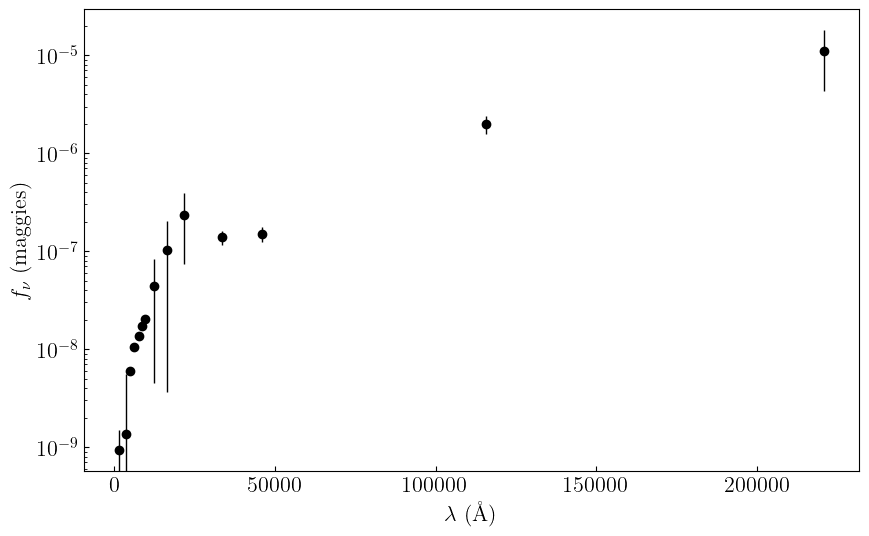

In [9]:
rc('font', size=16)  
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rcParams['figure.figsize'] = 10, 6
plt.rc('grid', color='gray', linestyle=':')
plt.rc('xtick', direction='in', color='black')
plt.rc('ytick', direction='in', color='black')

plt.errorbar(obs["phot_wave"],  obs["maggies"], yerr=obs["maggies_unc"], color="k",linestyle="",linewidth=1,marker='o')
plt.yscale("log")
plt.ylabel(r"$f_\nu$ (maggies)")
plt.xlabel(r"$\lambda$ (\AA)")

## We build the model 
Then, the next step is to create the model to describe our stellar populations. Since PROSPECTOR uses a bayesian approach, this means that we need to add aproppiate initial values and priors per each science case.
This initial values will describe what we assume for the redshift, the ages of the stellar populations, and the Star Formation Rates.
In this case we will use a non-parametric (Star Formation History) SFH + the fixed value for the redshift. 
See https://prospect.readthedocs.io/en/latest/sfhs.html for more details.

In [10]:
from astropy.cosmology import WMAP9 as cosmo
model_params = TemplateLibrary["continuity_sfh"]
 #We fit the known redshift
    
    
model_params["zred"]['isfree'] = False
model_params["zred"]["init"] = z_obs
    
nbins_sfh=5
    
model_params["nbins_sfh"] = dict(N=1, isfree=False, init=nbins_sfh)
model_params['agebins']['N'] = nbins_sfh
model_params['mass']['N'] = nbins_sfh
model_params['logsfr_ratios']['N'] = nbins_sfh-1
model_params['logsfr_ratios']['init'] = np.full(nbins_sfh-1, 0.0)  # constant SFH
model_params['logsfr_ratios']['prior'] = priors.StudentT(mean=np.full(nbins_sfh-1, 0.0),
                                                         scale=np.full(nbins_sfh-1, 0.3),
                                                         df=np.full(nbins_sfh-1, 2))
               
 # add redshift scaling to agebins, such that t_max = t_univ
def zred_to_agebins(zred=None, nbins_sfh=None, **extras):
        tuniv = np.squeeze(cosmo.age(zred).to("yr").value)
        ncomp = np.squeeze(nbins_sfh)
        tbinmax = (tuniv*0.9)
        agelims = [0.0, 7.4772] + np.linspace(8.0, np.log10(tbinmax), ncomp-2).tolist() + [np.log10(tuniv)]
        agebins = np.array([agelims[:-1], agelims[1:]])
        return agebins.T

def logmass_to_masses(logmass=None, logsfr_ratios=None, zred=None, **extras):
    agebins = zred_to_agebins(zred=zred, **extras)
    logsfr_ratios = np.clip(logsfr_ratios, -10, 10)  # numerical issues...
    nbins = agebins.shape[0]
    sratios = 10**logsfr_ratios
    dt = (10**agebins[:, 1] - 10**agebins[:, 0])
    coeffs = np.array([(1./np.prod(sratios[:i])) * (np.prod(dt[1:i+1]) / np.prod(dt[:i])) for i in range(nbins)])
    m1 = (10**logmass) / coeffs.sum()
    return m1 * coeffs

model_params['agebins']['depends_on'] = zred_to_agebins
model_params['mass']['depends_on'] = logmass_to_masses

  # --- metallicity (flat prior) ---
model_params["logzsol"]["prior"] = priors.TopHat(mini=-1.0, maxi=0.19)

  # --- complexify the dust ---
model_params['dust_type']['init'] = 4
model_params["dust2"]["prior"] = priors.ClippedNormal(mini=0.0, maxi=2.0, mean=0.3, sigma=1)
model_params["dust_index"] = dict(N=1, isfree=True, init=0,
                                        prior=priors.TopHat(mini=-1.0, maxi=0.2))

def to_dust1(dust1_fraction=None, dust1=None, dust2=None, **extras):
      return dust1_fraction*dust2

model_params['dust1'] = dict(N=1, isfree=False, init=0,
                                   prior=None, depends_on=to_dust1)
model_params['dust1_fraction'] = dict(N=1, isfree=True, init=1.0,prior=priors.ClippedNormal(mini=0.0, maxi=2.0, mean=1.0, sigma=0.3))

#model_params['duste_gamma'] = {'N':1, 'isfree':False, 'init':0.01}
#model_params['duste_umin'] = {'N':1, 'isfree':False, 'init':1.0}
#model_params['duste_qpah'] = {'N':1, 'isfree':False, 'init':2.0}

#We store all the initial fixed values and priors and build the model
model=SpecModel(model_params)   
print(model)

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-1.0,maxi=0.19)
  dust2: <class 'prospect.models.priors.ClippedNormal'>(mean=0.3,sigma=1,mini=0.0,maxi=2.0)
  logmass: <class 'prospect.models.priors.TopHat'>(mini=7,maxi=12)
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(mean=[0. 0. 0. 0.],scale=[0.3 0.3 0.3 0.3],df=[2 2 2 2])
  dust_index: <class 'prospect.models.priors.TopHat'>(mini=-1.0,maxi=0.2)
  dust1_fraction: <class 'prospect.models.priors.ClippedNormal'>(mean=1.0,sigma=0.3,mini=0.0,maxi=2.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.04059] 
  mass: [1000000.] <function logmass_to_masses at 0x7ff74d97ec10>
  sfh: [3] 
  imf_type: [2] 
  dust_type: [4] 
  agebins: [[ 0.  8.]
 [ 8.  9.]
 [ 9. 10.]] <function zred_to_agebins at 0x7ff74d97e9d0>
  nbins_sfh: [5] 
  dust1: [0] <function to_dust1 at 0x7ff74d97e940>


## Get the source: Stellar Population Synthesis
Then to properly model the SED we will need a "source" to use to fit the photometry using Stellar Synthesis Population. The choice of the model is dependent of the SFH that we selected.
For this case we will use one that is suitable for non-parametric SFH: FastStepBasis

In [11]:
sps = FastStepBasis(zcontinuous=1)

## Adding the noise
We add the noise to the model to make it more realistic. This can be done in different ways. In this case a simple gaussian noise is adopted.

In [12]:
noise_model = (None, None)

## We view the model

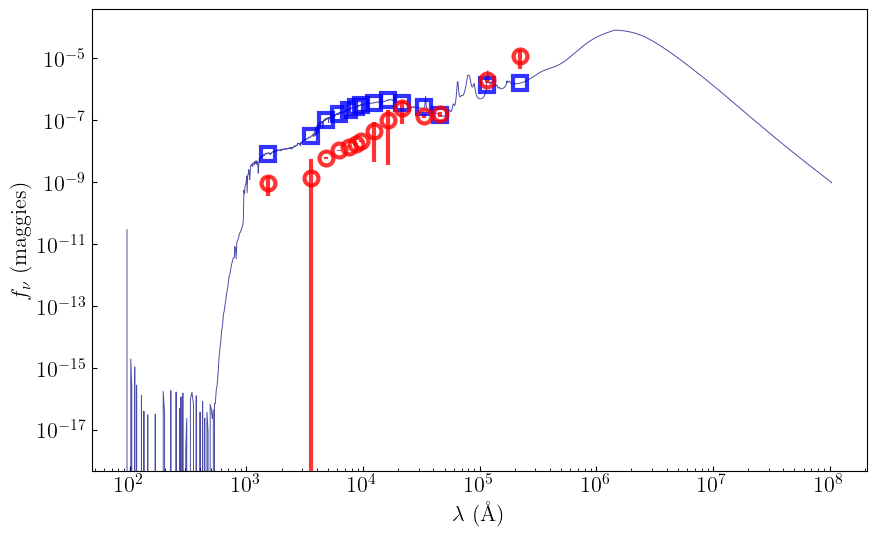

In [14]:
# Generate the model SED at the initial value of theta
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.predict(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]
    
rc('font', size=16)  
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rcParams['figure.figsize'] = 10, 6
plt.rc('grid', color='gray', linestyle=':')
plt.rc('xtick', direction='in', color='black')
plt.rc('ytick', direction='in', color='black')
    
plt.loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
plt.errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
plt.ylabel(r"$f_\nu$ (maggies)")
plt.xlabel(r"$\lambda$ (\AA)")
plt.savefig(target+'_'+analysis+'_'+ap+'kpc_emcee_model.pdf', format='pdf')
    


## Get the first guess: Minimization

In [15]:
# --- start minimization ----
run_params={}
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# We'll start minimization from "nmin" separate places, 
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 12

output = fit_model(obs, model, sps, lnprobfn=lnprobfn,noise=noise_model, **run_params)

print("Done optimization in {}s".format(output["optimization"][1]))

/home/goio/miniconda3/envs/prospector/lib/python3.8/site-packages/prospect/models/priors.py:120: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)


Done optimization in 146.98925161361694s


## View optimization results

[ -0.87482666   1.71519111   8.60929126  18.02127066 -38.89312907
  23.76650687  14.22274126   0.19999944   1.42171236]
10
[ -0.87482666   1.71519111   8.60929126  18.02127066 -38.89312907
  23.76650687  14.22274126   0.19999944   1.42171236]


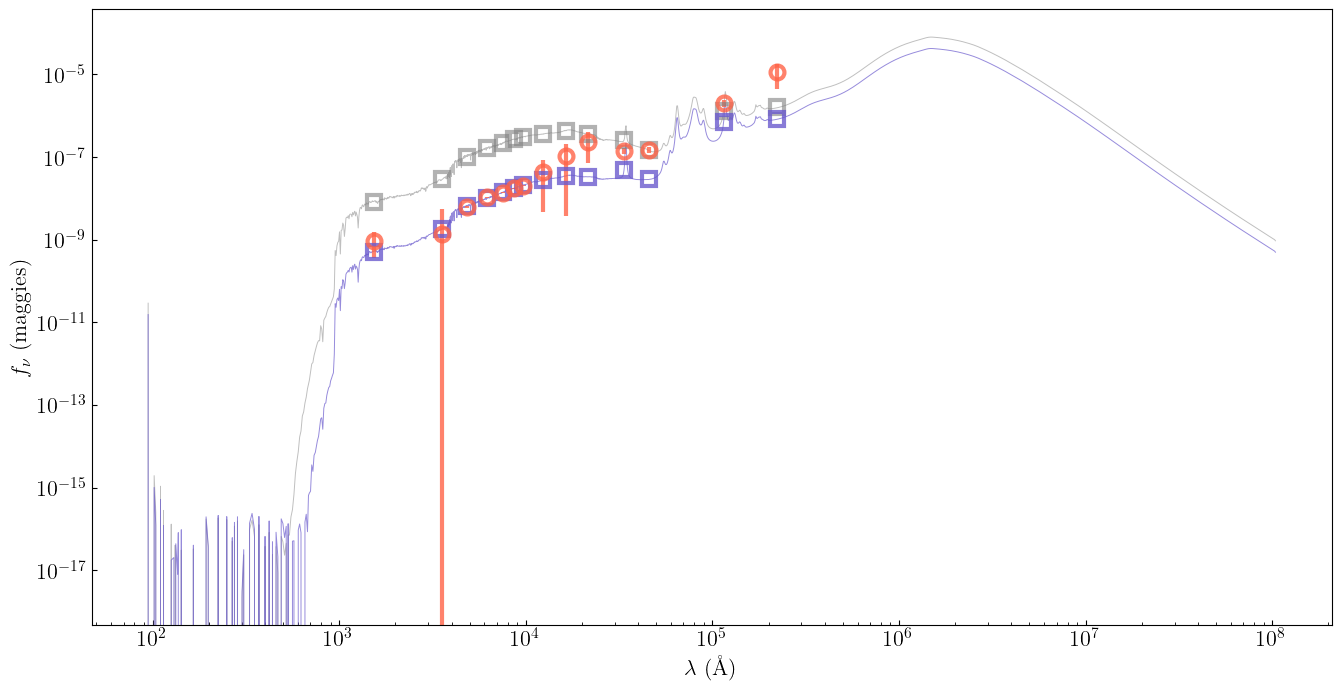

In [16]:
print(model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print(ind_best)
theta_best = results[ind_best].x.copy()
print(theta_best)

# generate model
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

plt.figure(figsize=(16,8))

# plot Data, best fit model, and old models
plt.loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
plt.errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
plt.loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7)
plt.errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='slateblue', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

plt.ylabel(r"$f_\nu$ (maggies)")
plt.xlabel(r"$\lambda$ (\AA)")
plt.savefig(target+'_'+analysis+'_'+ap+'kpc_emcee_optimization.pdf', format='pdf')

## Run the fit
Then we will proceed to the fit. We can use optimize, dynesty or emcee. 
In this case we will be using emcee. You can read more about it here: https://emcee.readthedocs.io/en/stable/
WARNING: It will take a while.

In [17]:
# Set this to False if you don't want to do another optimization
# before emcee sampling (but note that the "optimization" entry 
# in the output dictionary will be (None, 0.) in this case)
# If set to true then another round of optmization will be performed 
# before sampling begins and the "optmization" entry of the output
# will be populated.
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False
# Number of emcee walkers
run_params["nwalkers"] = 128
# Number of iterations of the MCMC sampling
run_params["niter"] = 1024
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [16, 32, 64]

output = fit_model(obs, model, sps, lnprobfn=lnprobfn, noise=noise_model, **run_params)

print('done emcee in {0}s'.format(output["sampling"][1]))

number of walkers=128
done burn #0 (16 iterations)
done burn #1 (32 iterations)
done burn #2 (64 iterations)
number of walkers=128
starting production
done production
done emcee in 942.7646751403809s


In [18]:
from prospect.io import write_results as writer
fit_type='emcee'
hfile = "./PROSPECTOR/"+target+"_"+fit_type+"_mcmc.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                 output["sampling"][0], output["optimization"][0],
                 sps=sps,
                 tsample=output["sampling"][1],
                 toptimize=output["optimization"][1])

/home/goio/miniconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/home/goio/miniconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/home/goio/miniconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


## We read the file 
We use Prospector libraries to read the written file with the obtained results. The out dictionary gives information about the fitting parameters and weights, out_obs contains the input values (the observed photometry) and out_model the model values: modeled photometry and SED. 

In [7]:
import prospect.io.read_results as reader
results_type = "emcee"
target = '2001ah'
ap = None
analysis = 'global'

apstr = '_' + ap if ap is not None else ''
hfile = "./PROSPECT_results/"+target+"_"+results_type+"_"+analysis+apstr+"_mcmc.h5"
print(hfile)
print(Path(hfile).exists())
out, out_obs,out_model = reader.results_from(hfile)
print(out_model)
    

./PROSPECT_results/2001ah_emcee_local_3_mcmc.h5
True
None


## Plotting the results

[ 0.49982073 -0.44405721  0.57326319 -0.52998676  0.44133336 -0.58390723
  0.2075523   0.62808683  0.16256744  0.22631132]


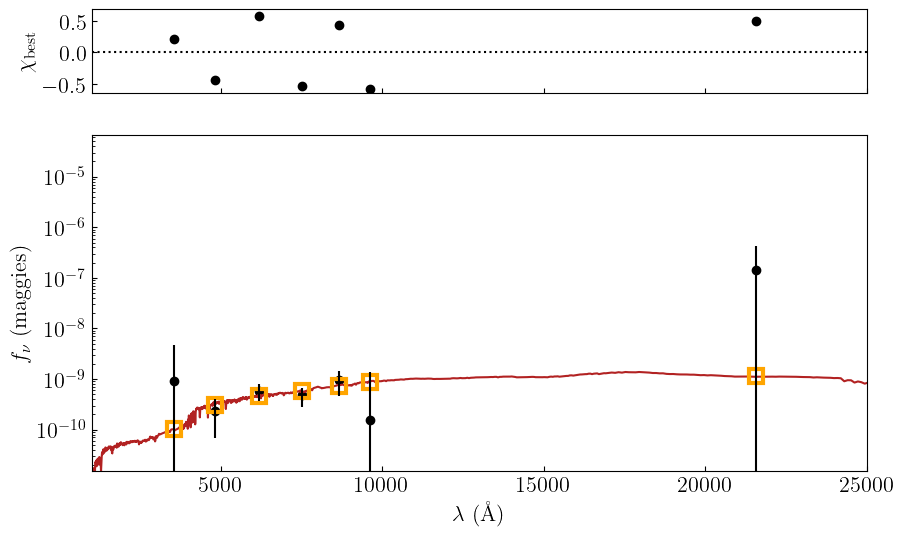

In [8]:
rc('font', size=16)  
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rcParams['figure.figsize'] = 10, 6
plt.rc('grid', color='gray', linestyle=':')
plt.rc('xtick', direction='in', color='black')
plt.rc('ytick', direction='in', color='black')



import matplotlib.pyplot as plt
sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True)
ax = saxes[1]
pwave = out_obs["phot_wave"]
# plot the data
ax.plot(pwave, out_obs["maggies"], linestyle="", marker="o", color="k")
ax.errorbar(pwave,  out_obs["maggies"], out_obs["maggies_unc"], linestyle="", color="k", zorder=10)
ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel(r"$\lambda$ (\AA)")
ax.set_xlim(1e3, 2.5e4)
ax.set_ylim(out_obs["maggies"].min() * 0.1, out_obs["maggies"].max() * 5)
ax.set_yscale("log")

# get the best-fit SED
bsed = out["bestfit"]
ax.plot(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]), bsed["spectrum"], color="firebrick", label="MAP sample")
ax.plot(pwave, bsed["photometry"], linestyle="", marker="s", markersize=10, mec="orange", mew=3, mfc="none")

ax = saxes[0]
chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
print(chi)
ax.plot(pwave, chi, linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylabel(r"$\chi_{\rm best}$")
#plt.savefig(target+'_'+analysis+'_'+ap+'kpc_emcee_bestfitSED.pdf', format='pdf')

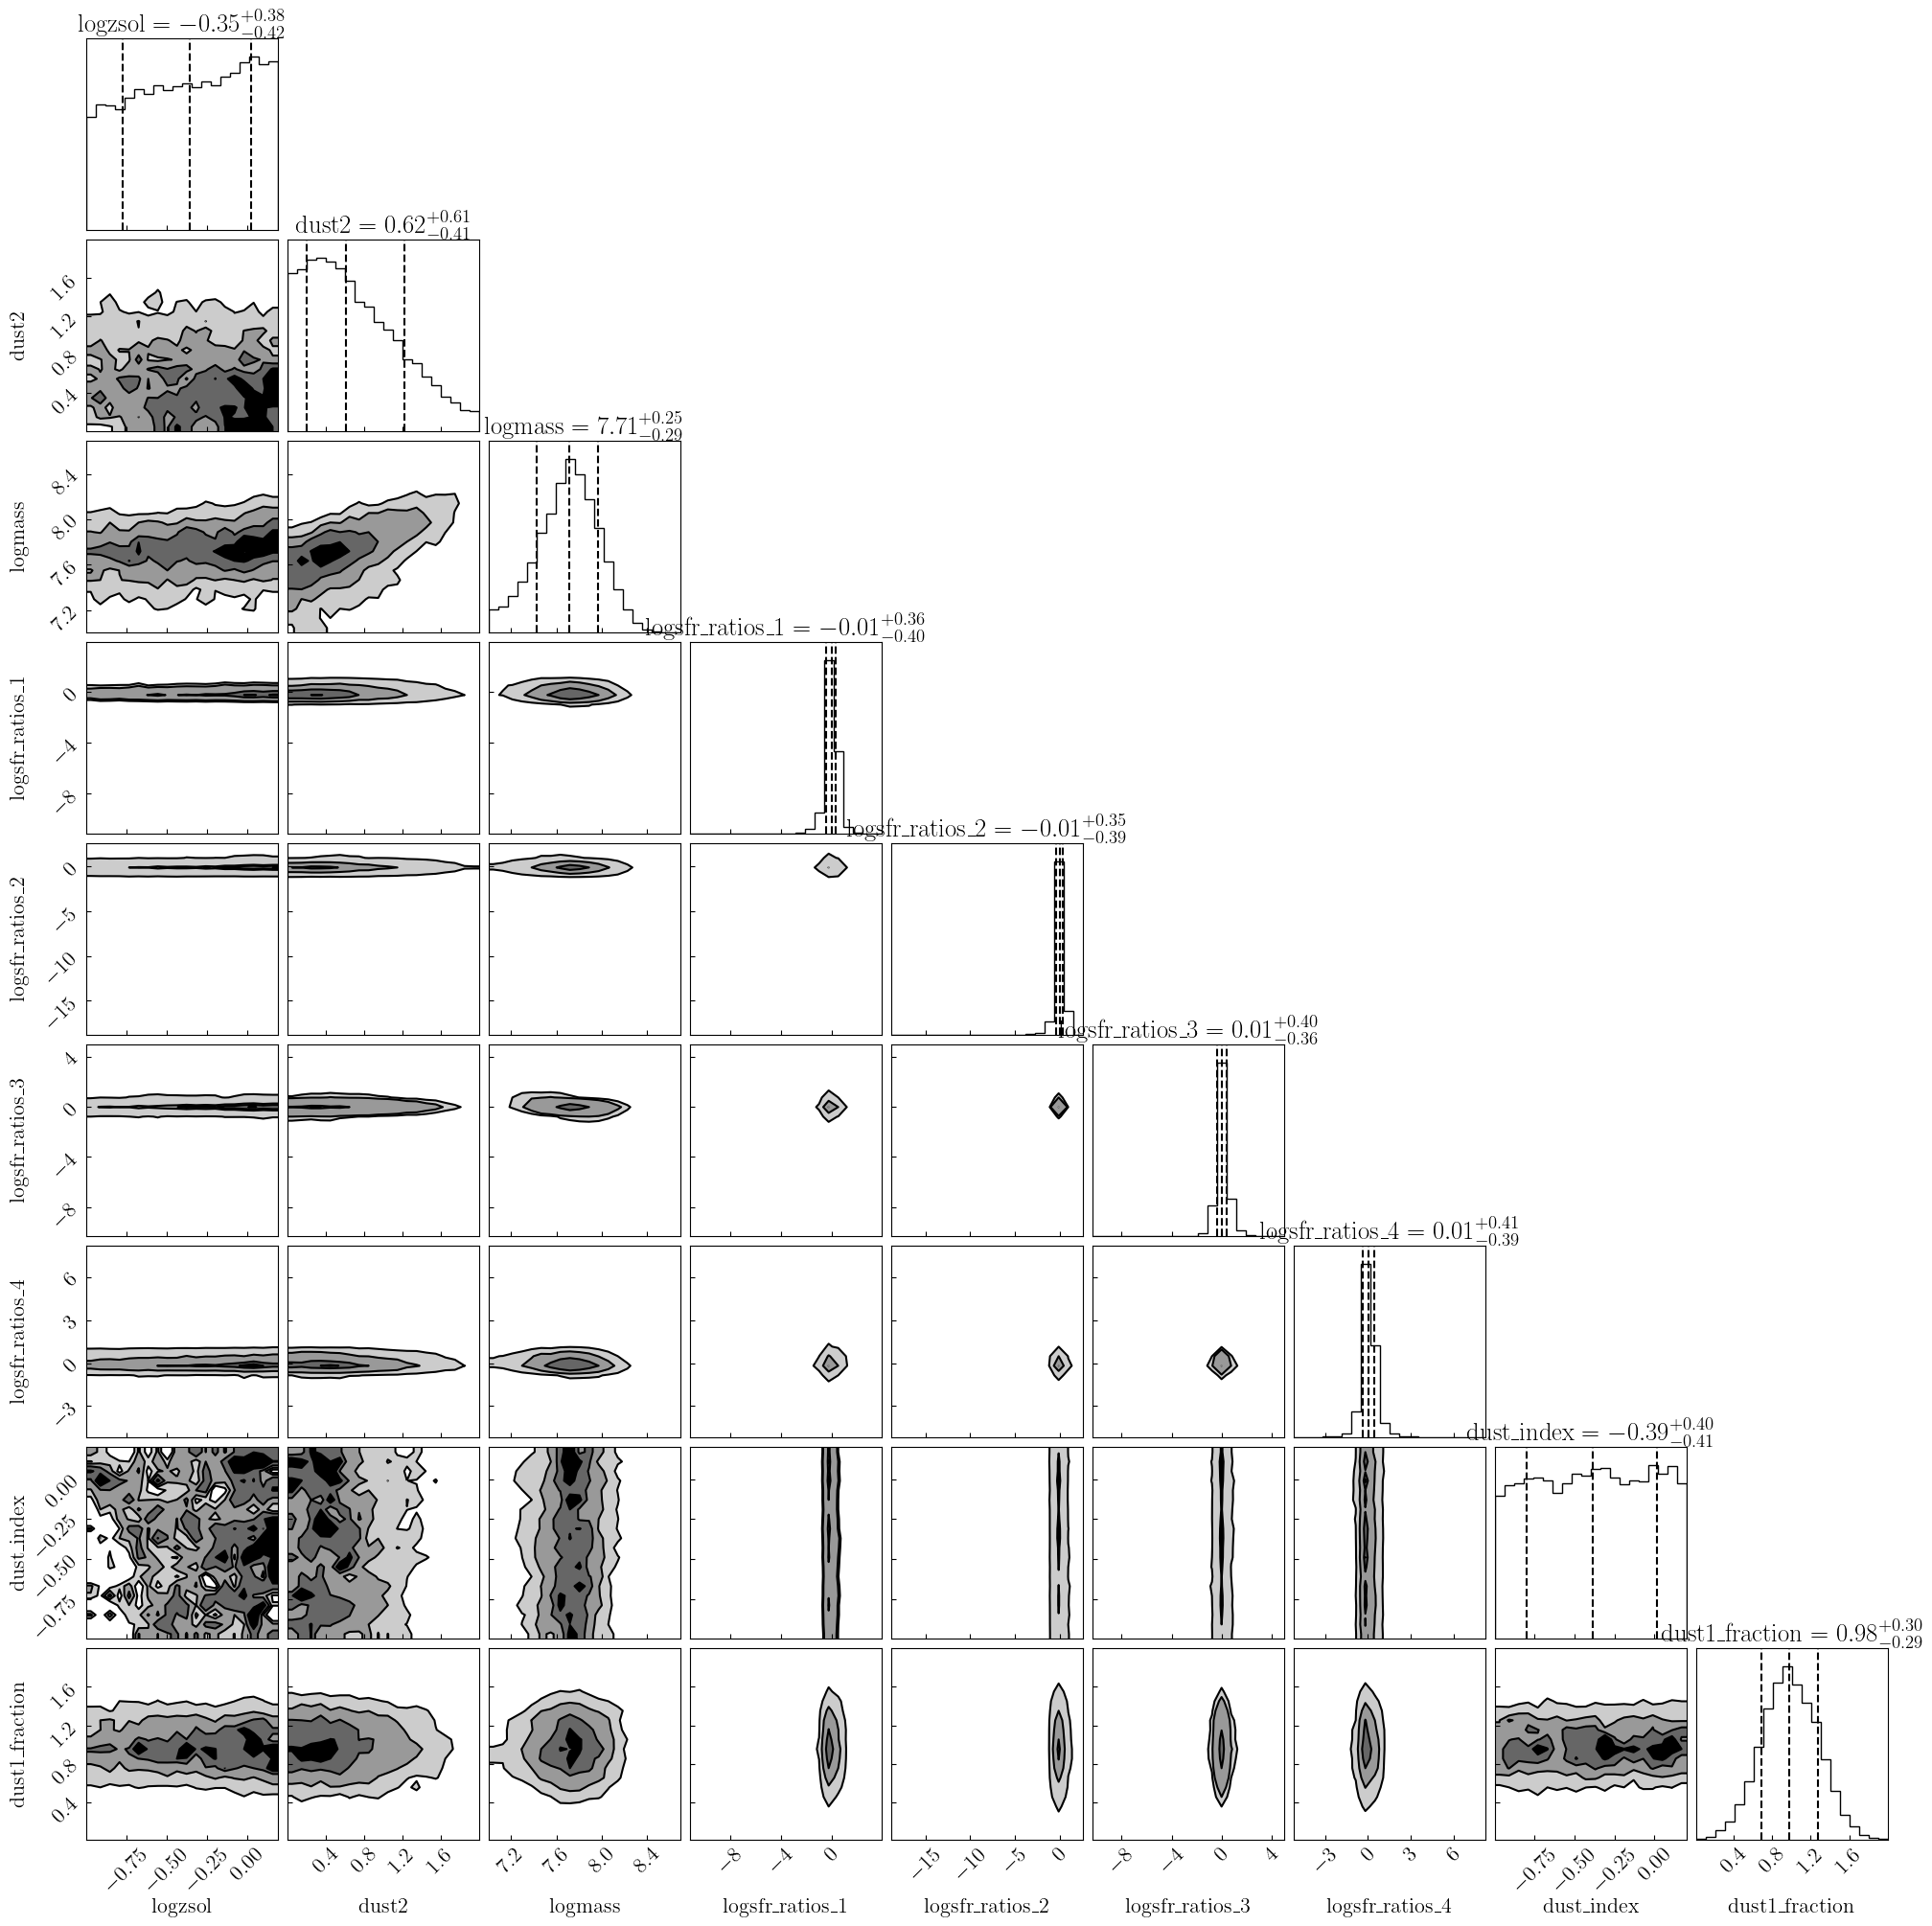

In [14]:
import corner


# Corner figure of posterior PDFs
cfig = reader.subcorner(out)
#plt.savefig(target+'_'+analysis+'_'+ap+'kpc_emcee_cornerplot.pdf', format='pdf')

## Read the outputs

In [13]:
import prospect.io.read_results as reader

print('The results for the best fit are',out['bestfit'])


The results for the best fit are {'parameter': array([ 2.47281497e-02,  3.59557844e-01,  7.78566313e+00,  3.16147495e-02,
       -4.95227871e-02,  7.23268201e-03, -3.04896036e-02,  1.01646738e-01,
        9.70227975e-01]), 'photometry': array([1.13001833e-09, 3.12521397e-10, 4.58965036e-10, 5.87500287e-10,
       7.38501985e-10, 8.76706258e-10, 1.00928480e-10, 7.55553680e-10,
       4.59857809e-10, 3.07618045e-09]), 'restframe_wavelengths': array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
       1.000e+08]), 'spectrum': array([ 5.55797750e-14, -6.26420528e-17, -1.04999011e-18, ...,
        1.95513377e-12,  1.90355693e-12,  1.79869040e-12]), 'mfrac': 0.626648499622305}


In [32]:
import numpy as np
# Find the index of the maximum a posteriori sample
ind_max = out["lnprobability"].argmax()
if out["chain"].ndim > 2:
    # emcee
    walker, iteration = np.unravel_index(ind_max, out["lnprobability"].shape)
    theta_max = out["chain"][walker, iteration, :]
elif out["chain"].ndim == 2:
    # dynesty
    theta_max = out["chain"][ind_max, :]

# now generate the SED for the max. a post. parameters
spec, phot, x = model.predict(theta_max, obs=obs, sps=sps)
spec, mags, sm = model.mean_model(theta_max,sps=sps,obs=obs)
stellar_mass = (10**model.params['logmass']) * sm

print(stellar_mass)


[2.10119835e+08]


In [12]:
for key, value in out.items():
    print(key)
    print(value)
    print()

model_params
[{'N': 1, 'isfree': False, 'init': 0.05891, 'units': 'redshift', 'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G\x00\x00\x00\x00\x00\x00\x00\x00h\x06G@\x10\x00\x00\x00\x00\x00\x00uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.', 'name': 'zred'}, {'N': 5, 'isfree': False, 'init': 1000000.0, 'units': 'M$_\\odot$', 'depends_on': ['logmass_to_masses', '__main__'], 'name': 'mass'}, {'N': 1, 'isfree': True, 'init': -0.5, 'units': '$\\log (Z/Z_\\odot)$', 'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G\xbf\xf0\x00\x00\x00\x00\x00\x00h\x06G?\xc8Q\xeb\x85\x1e\xb8RuX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.', 'name': 'logzsol'}, {'N': 1, 'isfree': True, 

In [15]:
os.listdir('PROSPECT_results')

['2001V_emcee_local_4_mcmc.h5',
 '2006ac_emcee_local_2_mcmc.h5',
 '2006kf_emcee_local_1_mcmc.h5',
 '2003ai_emcee_local_1_mcmc.h5',
 '2006mp_emcee_local_2_mcmc.h5',
 '2001V_emcee_local_1_mcmc.h5',
 '2003ai_emcee_global_mcmc.h5',
 '2006al_emcee_local_4_mcmc.h5',
 '2006mp_emcee_local_1_mcmc.h5',
 '2004ef_emcee_local_2_mcmc.h5',
 '2006kf_emcee_local_3_mcmc.h5',
 '2006cq_emcee_local_3_mcmc.h5',
 '2001G_emcee_global_mcmc.h5',
 '2006N_emcee_local_3_mcmc.h5',
 '2003it_emcee_global_mcmc.h5',
 '2004as_emcee_local_4_mcmc.h5',
 '2001az_emcee_local_1_mcmc.h5',
 '2006eq_emcee_local_1_mcmc.h5',
 '2006ev_emcee_global_mcmc.h5',
 '2002jy_emcee_local_4_mcmc.h5',
 '2005bo_emcee_global_mcmc.h5',
 '2006eq_emcee_local_2_mcmc.h5',
 '2002hu_emcee_local_1_mcmc.h5',
 '2006cp_emcee_local_1_mcmc.h5',
 '2005bo_emcee_local_4_mcmc.h5',
 '2003ch_emcee_local_3_mcmc.h5',
 '2003it_emcee_local_1_mcmc.h5',
 '2006eq_emcee_global_mcmc.h5',
 '2003ic_emcee_local_2_mcmc.h5',
 '2006kf_emcee_global_mcmc.h5',
 '2006lu_emcee_local_

# Histograms

### Global

In [38]:
params_list = []
results_path = Path('PROSPECT_results')
for handle in [f for f in os.listdir(results_path) if 'global' in f]:
    out, out_obs,out_model = reader.results_from(str(results_path / handle))
    params_list.append(out['bestfit']['parameter'])
logzsol, dust2, logmass, logfsr_ratios1, logfsr_ratios2, logfsr_ratios3, logfsr_ratios4, dust_index, dust1_fraction = zip(*params_list)

logzsol


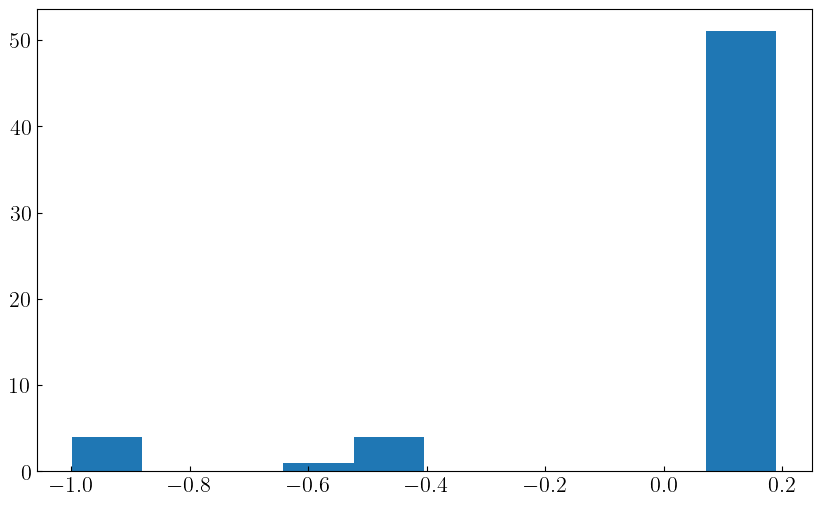

dust2


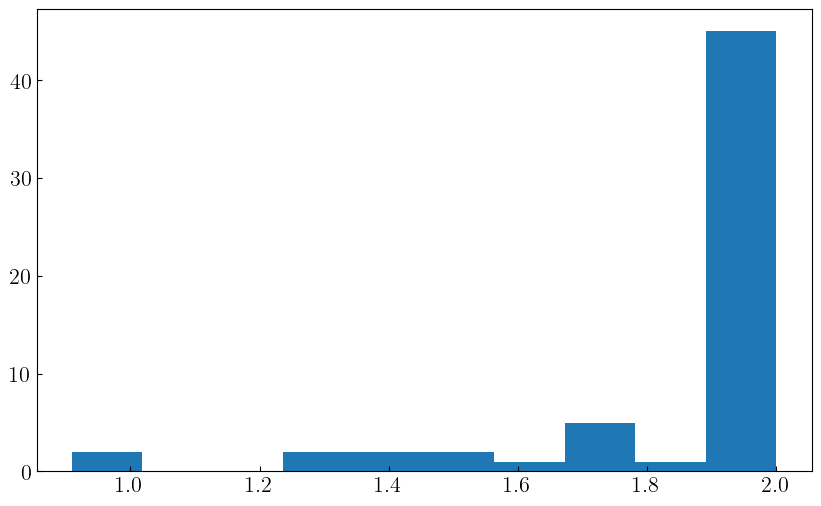

logmass


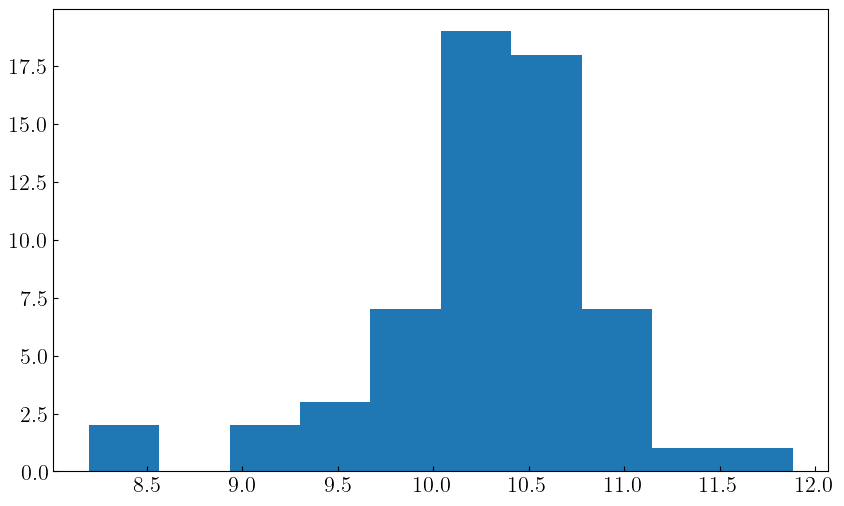

logfsr_ratios1


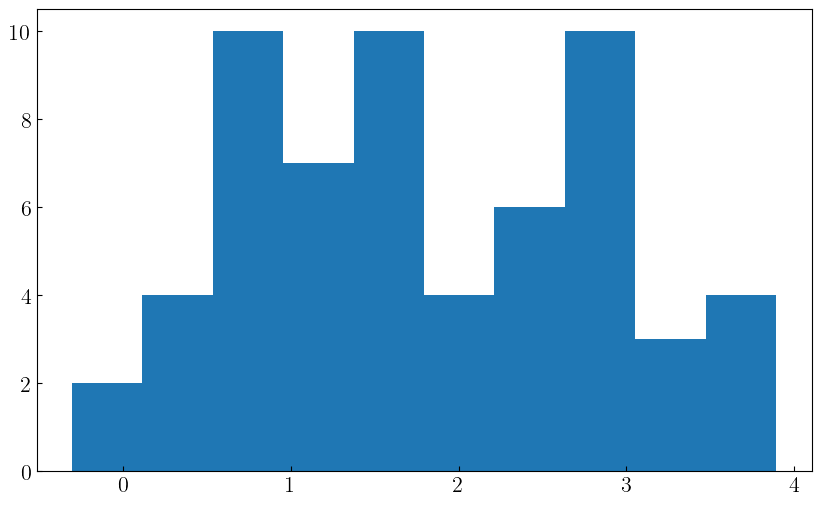

logfsr_ratios2


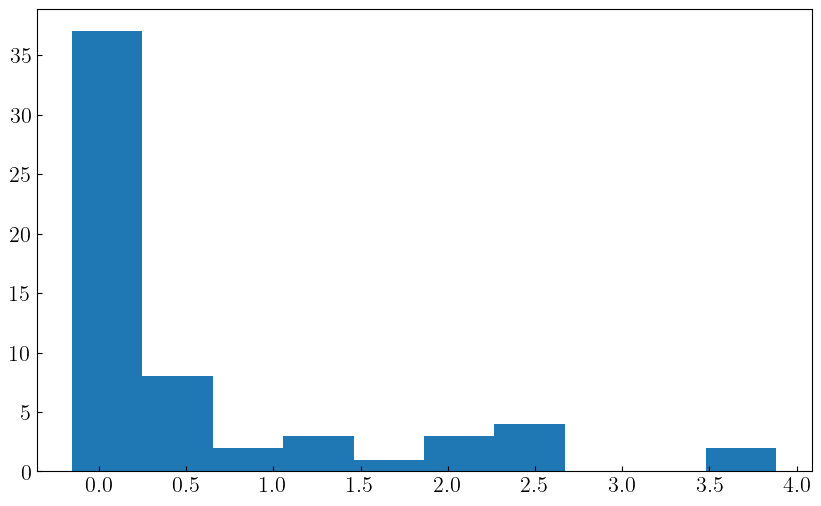

logfsr_ratios3


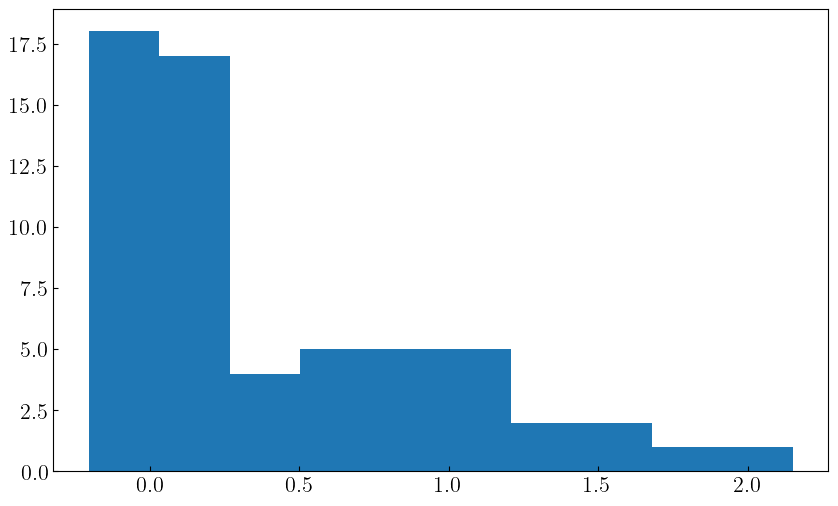

logfsr_ratios4


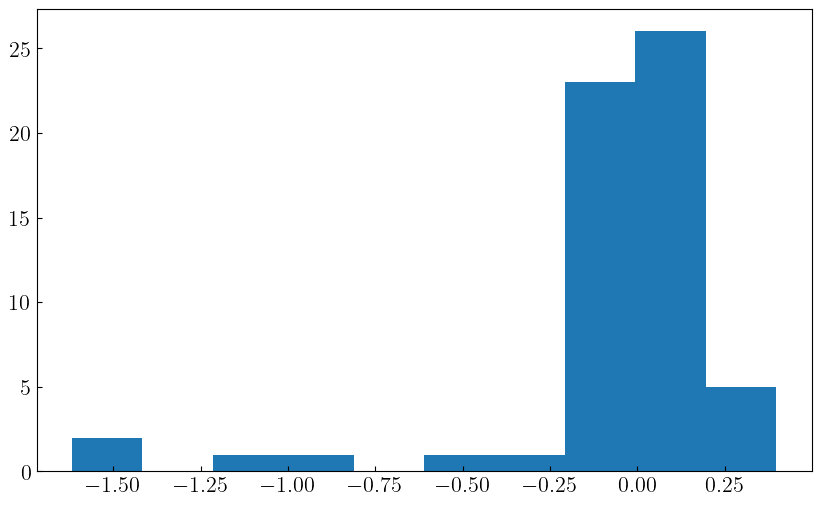

dust_index


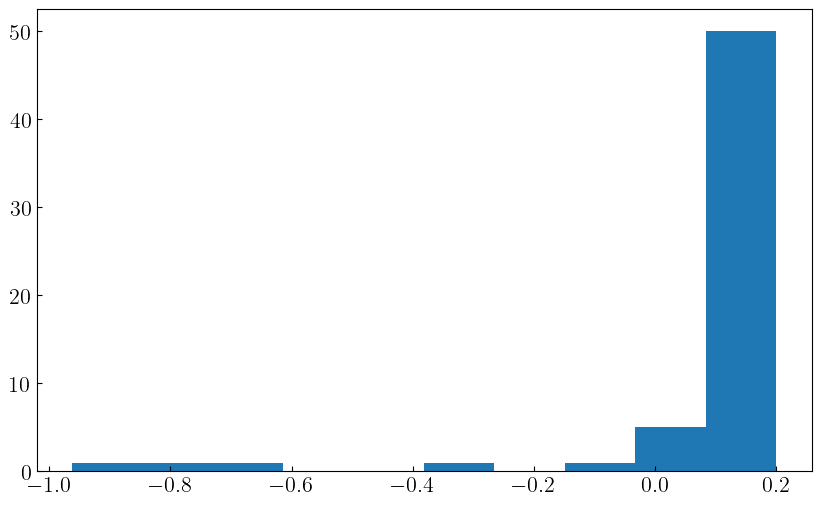

dust1_fraction


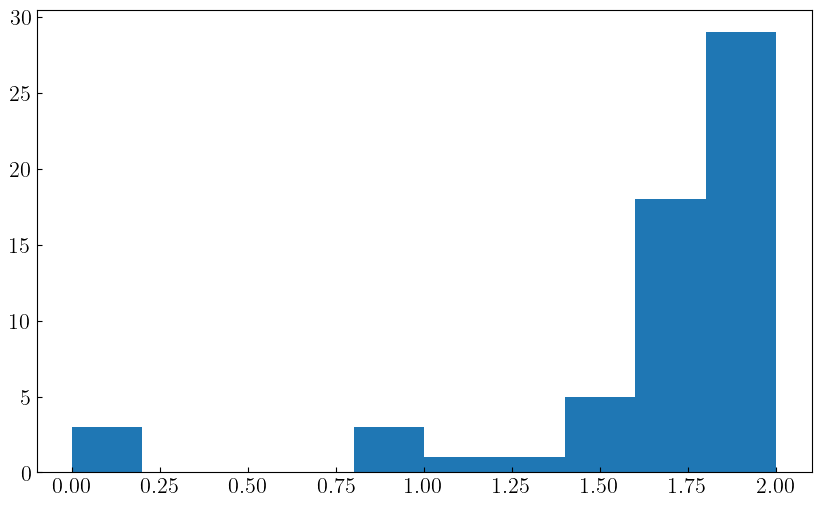

In [39]:
param_names = ["logzsol", "dust2", "logmass", "logfsr_ratios1", "logfsr_ratios2", "logfsr_ratios3", "logfsr_ratios4", "dust_index", "dust1_fraction"]
for param, name in zip(zip(*params_list),param_names):
    print(name)
    plt.hist(param)
    plt.show()

### Local 1

logzsol


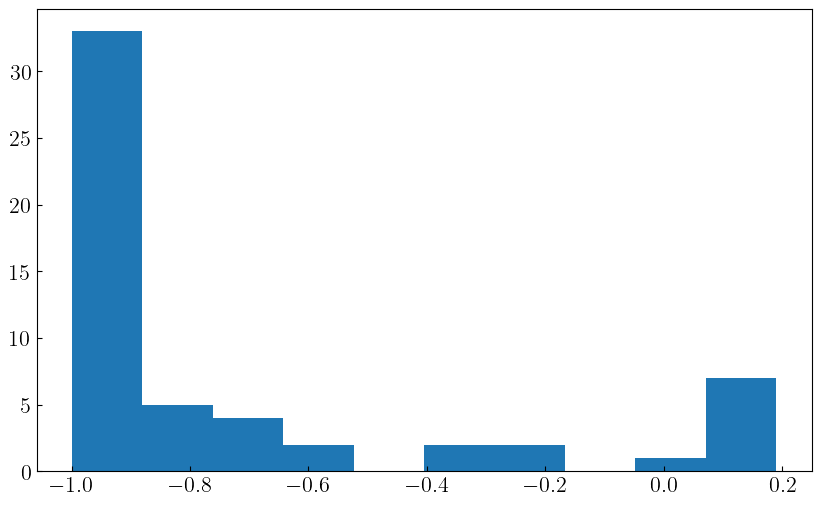

dust2


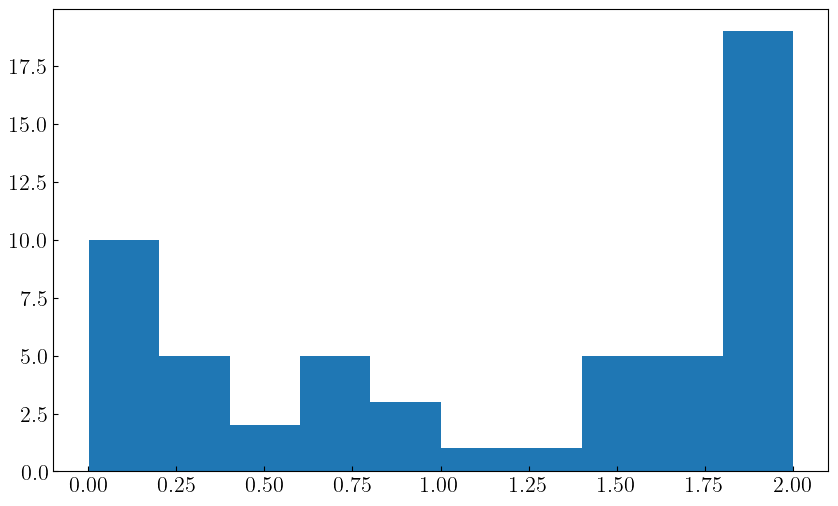

logmass


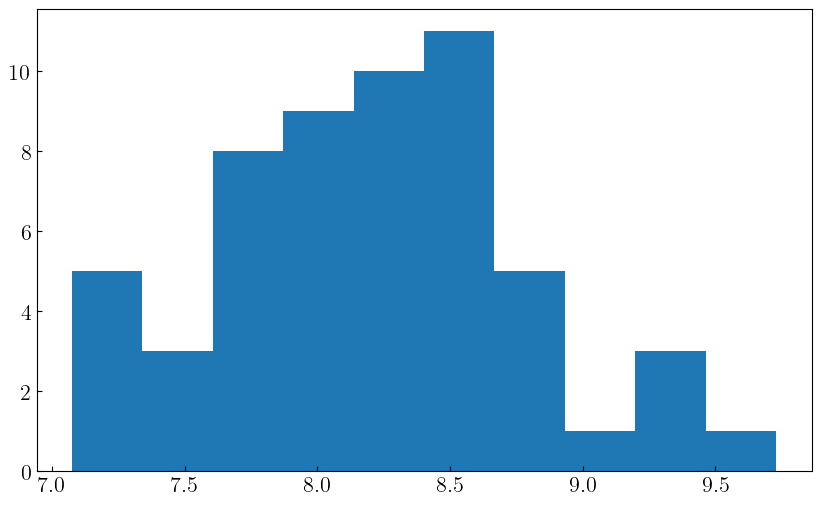

logfsr_ratios1


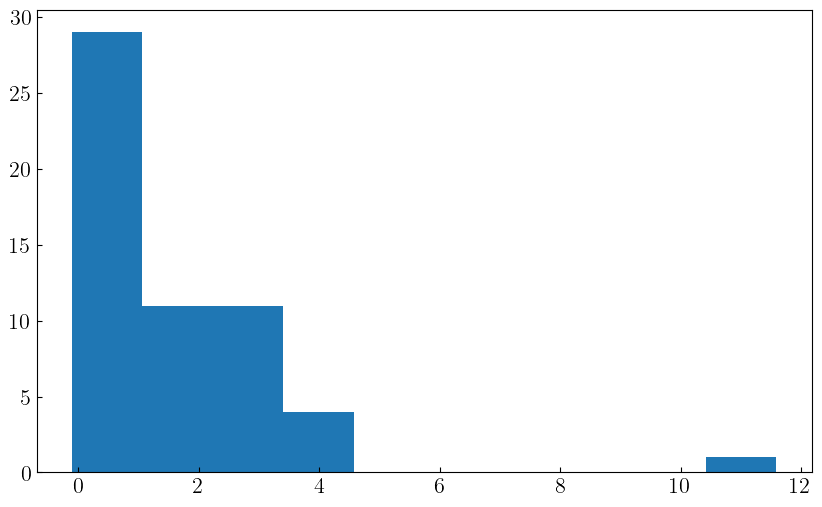

logfsr_ratios2


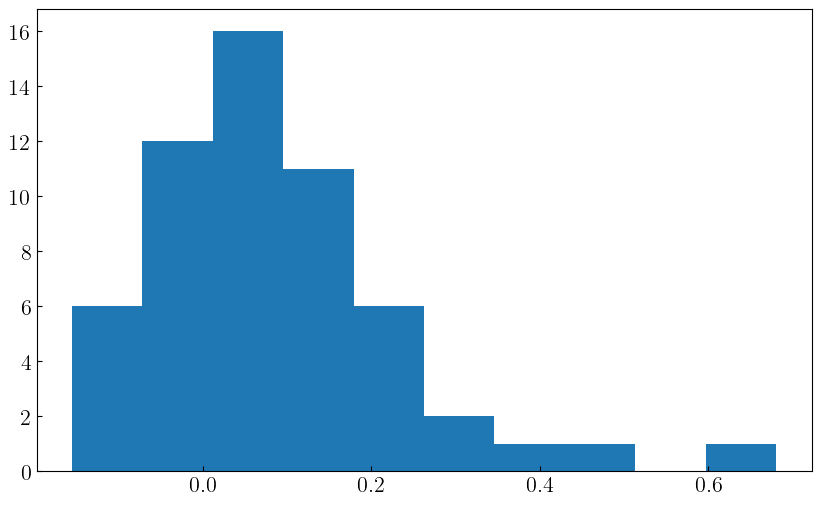

logfsr_ratios3


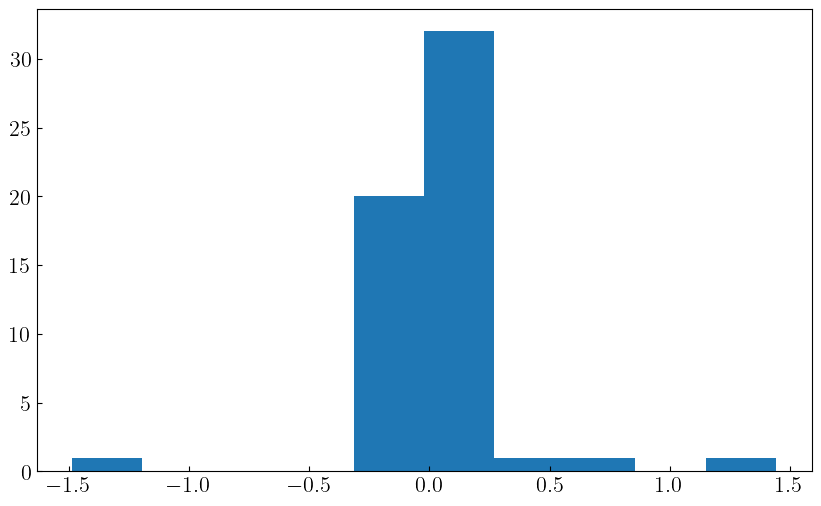

logfsr_ratios4


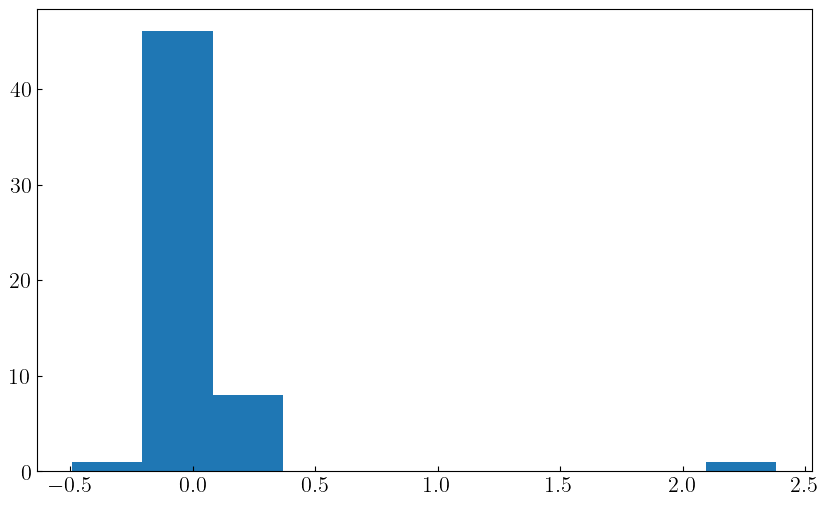

dust_index


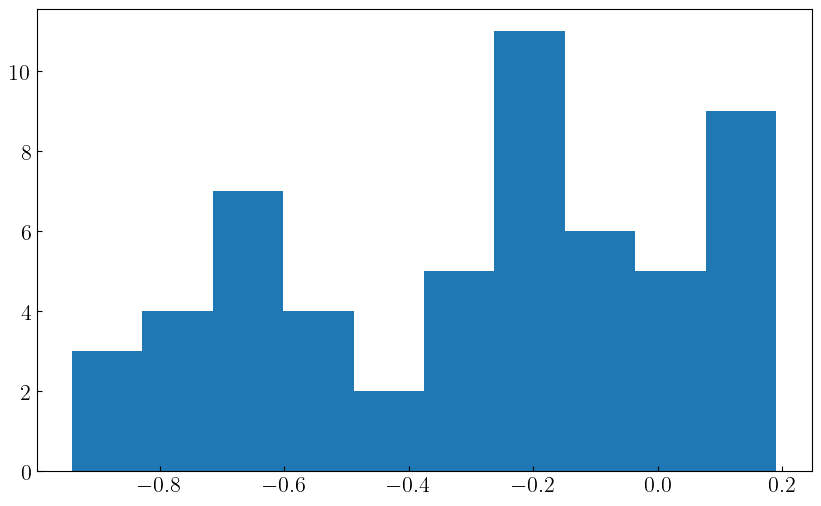

dust1_fraction


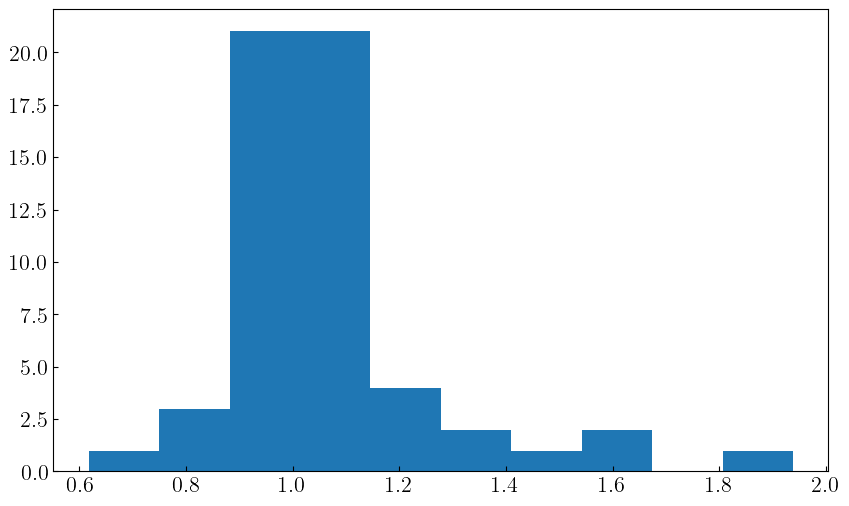

In [40]:
params_list = []
results_path = Path('PROSPECT_results')
for handle in [f for f in os.listdir(results_path) if 'local_1' in f]:
    out, out_obs,out_model = reader.results_from(str(results_path / handle))
    params_list.append(out['bestfit']['parameter'])
logzsol, dust2, logmass, logfsr_ratios1, logfsr_ratios2, logfsr_ratios3, logfsr_ratios4, dust_index, dust1_fraction = zip(*params_list)

param_names = ["logzsol", "dust2", "logmass", "logfsr_ratios1", "logfsr_ratios2", "logfsr_ratios3", "logfsr_ratios4", "dust_index", "dust1_fraction"]
for param, name in zip(zip(*params_list),param_names):
    print(name)
    plt.hist(param)
    plt.show()

### Local 2

logzsol


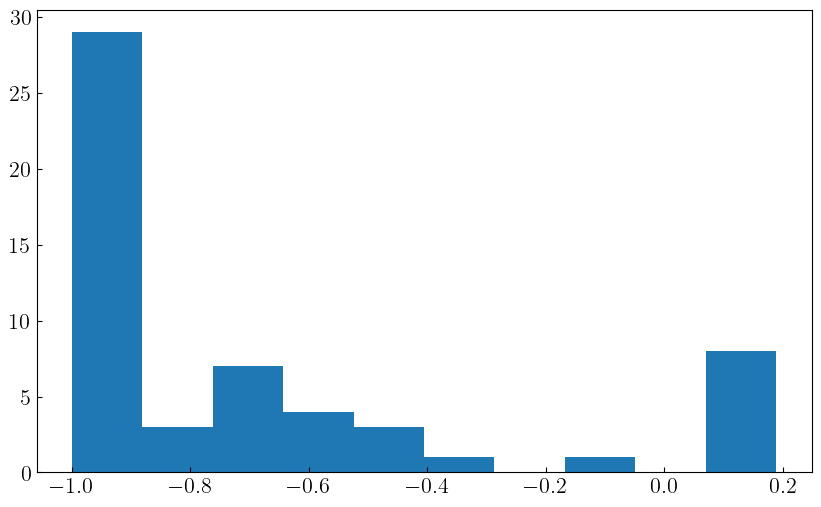

dust2


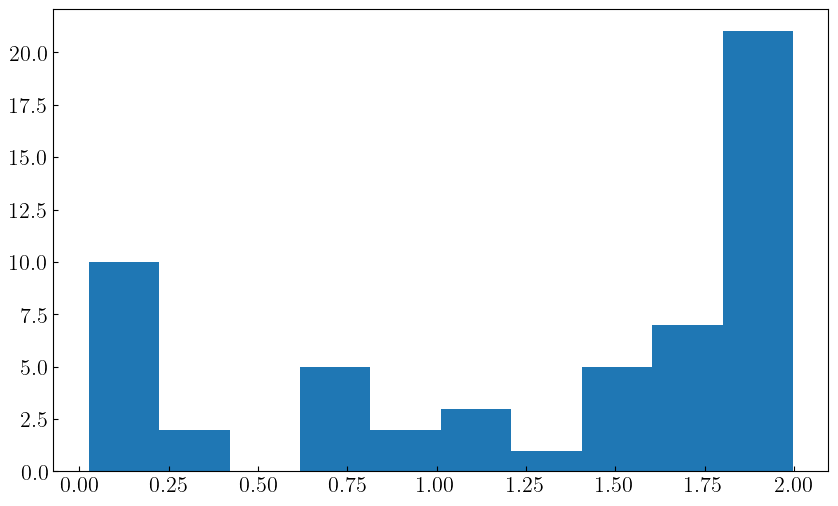

logmass


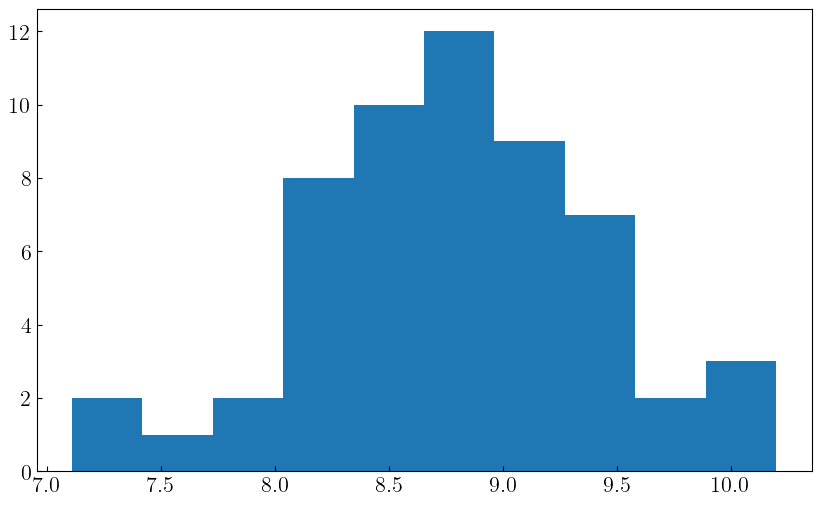

logfsr_ratios1


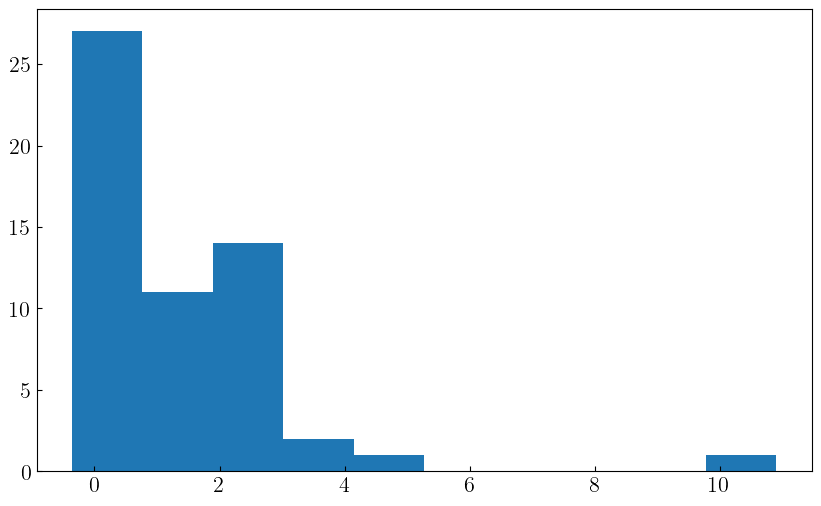

logfsr_ratios2


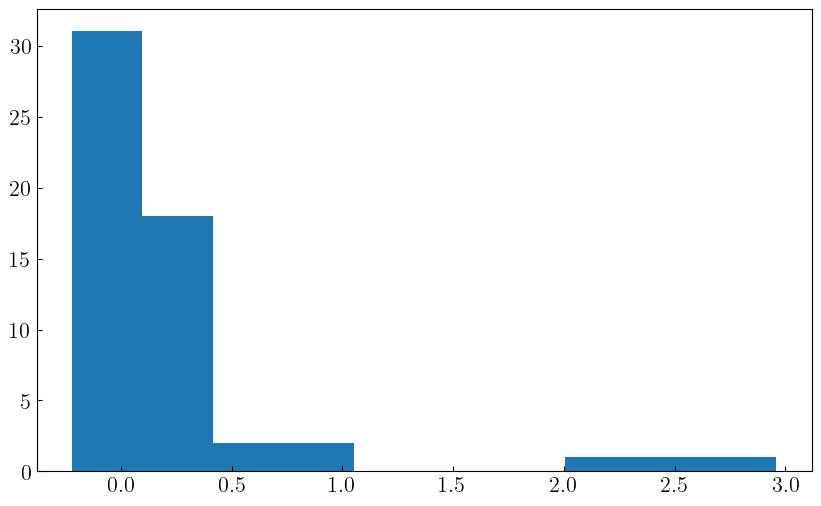

logfsr_ratios3


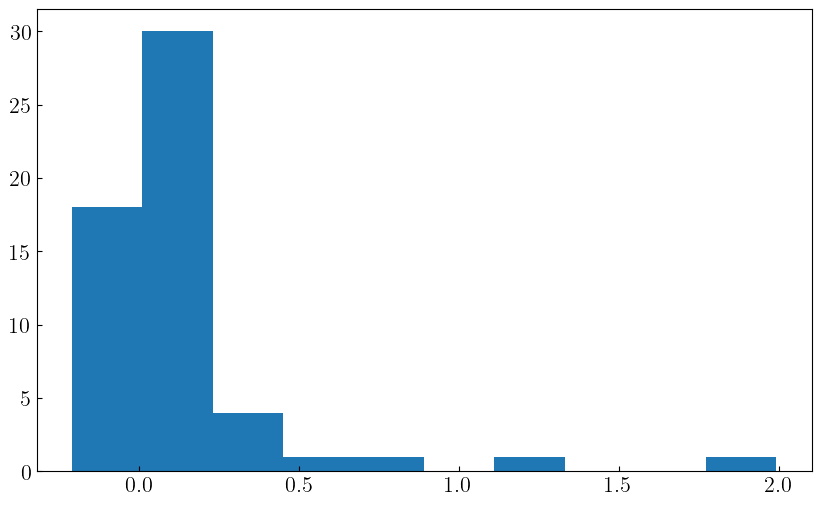

logfsr_ratios4


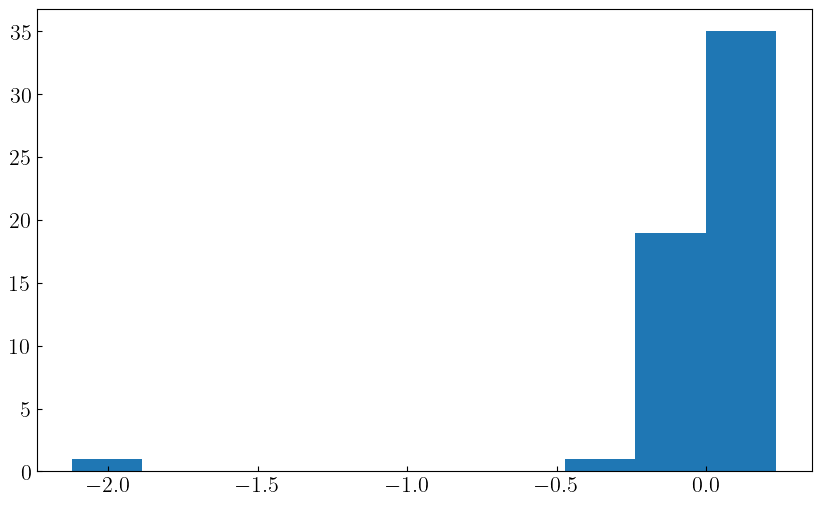

dust_index


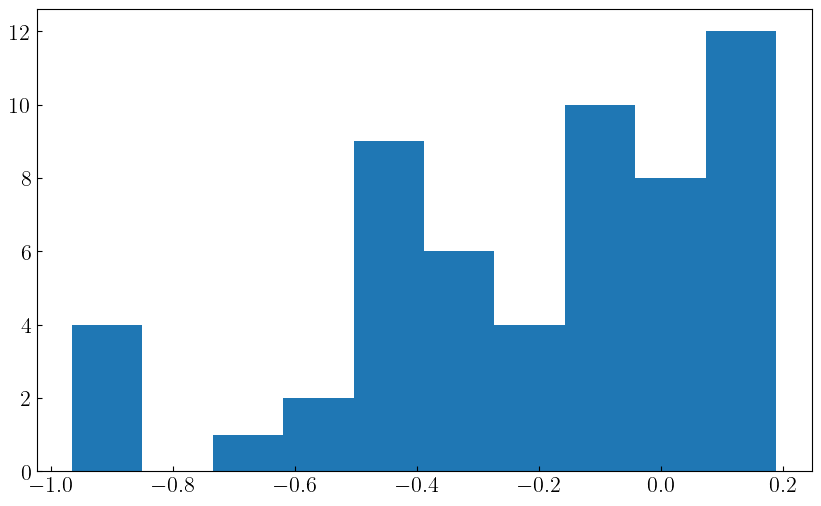

dust1_fraction


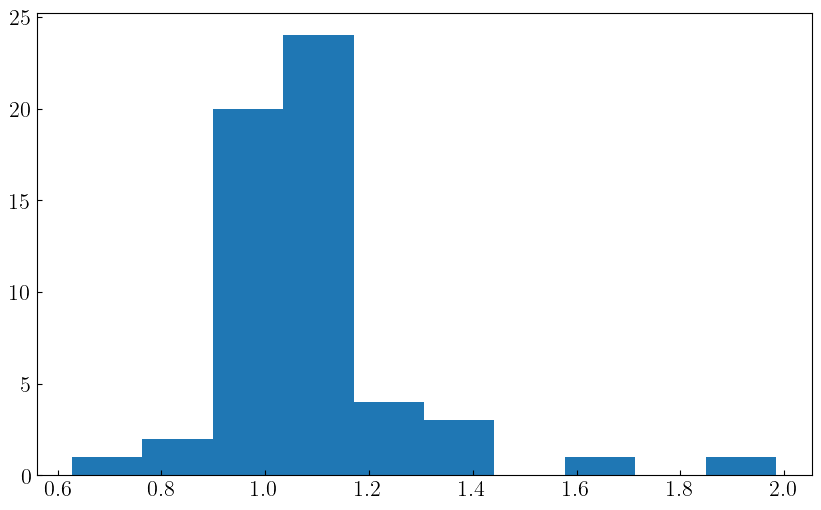

In [41]:
params_list = []
results_path = Path('PROSPECT_results')
for handle in [f for f in os.listdir(results_path) if 'local_2' in f]:
    out, out_obs,out_model = reader.results_from(str(results_path / handle))
    params_list.append(out['bestfit']['parameter'])
logzsol, dust2, logmass, logfsr_ratios1, logfsr_ratios2, logfsr_ratios3, logfsr_ratios4, dust_index, dust1_fraction = zip(*params_list)

param_names = ["logzsol", "dust2", "logmass", "logfsr_ratios1", "logfsr_ratios2", "logfsr_ratios3", "logfsr_ratios4", "dust_index", "dust1_fraction"]
for param, name in zip(zip(*params_list),param_names):
    print(name)
    plt.hist(param)
    plt.show()

### Local 3

logzsol


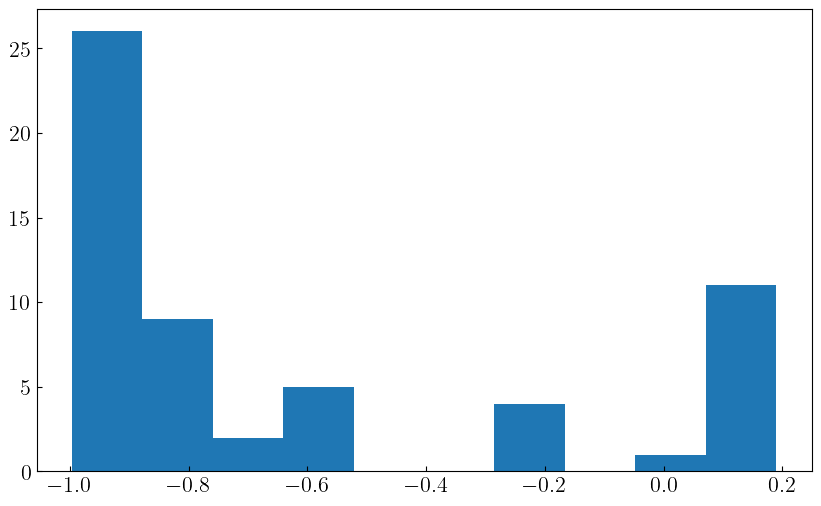

dust2


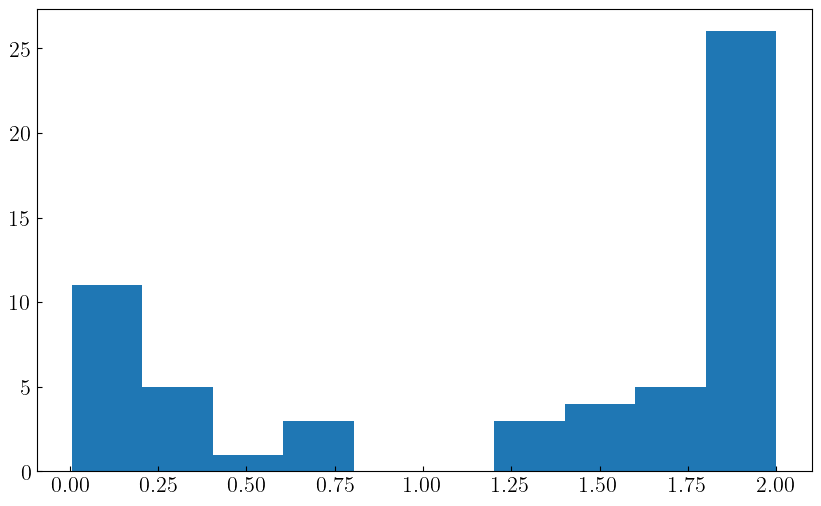

logmass


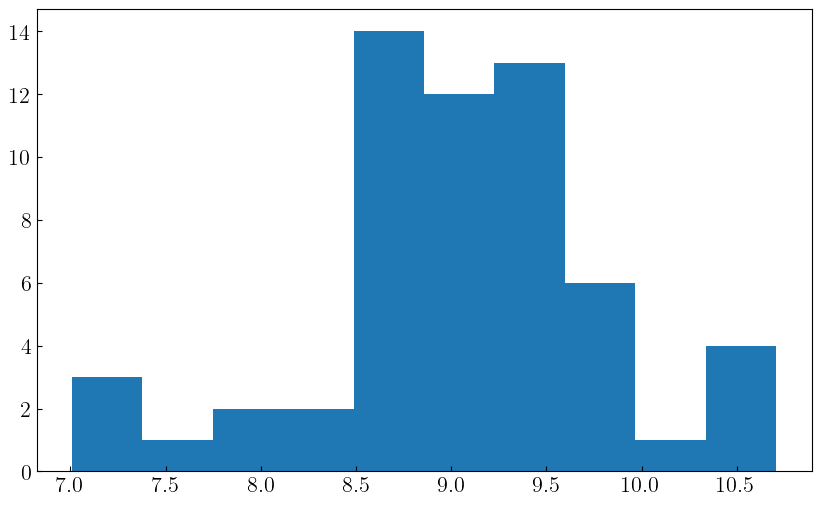

logfsr_ratios1


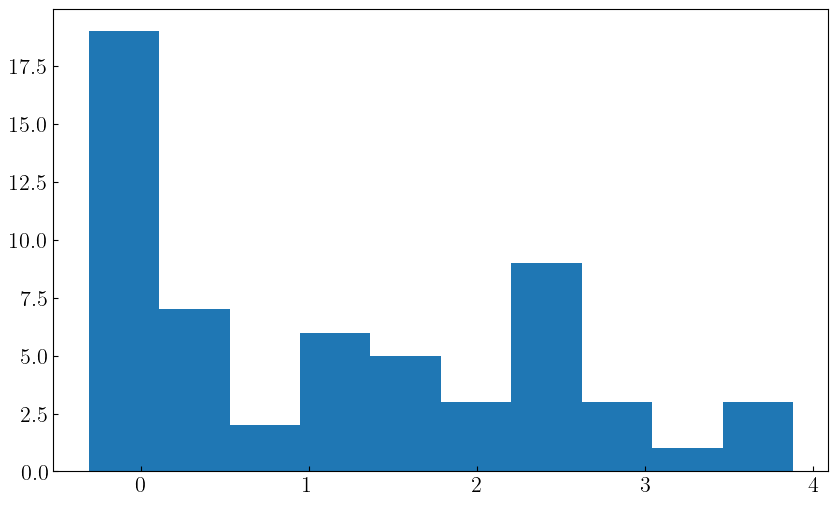

logfsr_ratios2


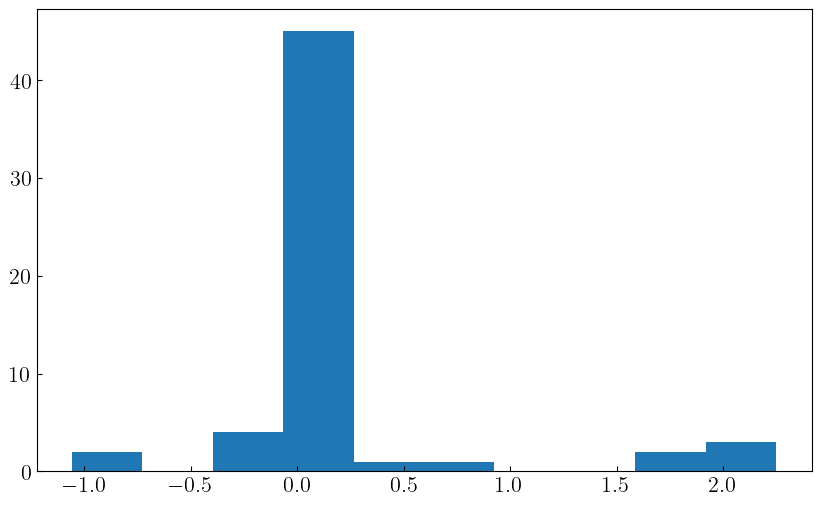

logfsr_ratios3


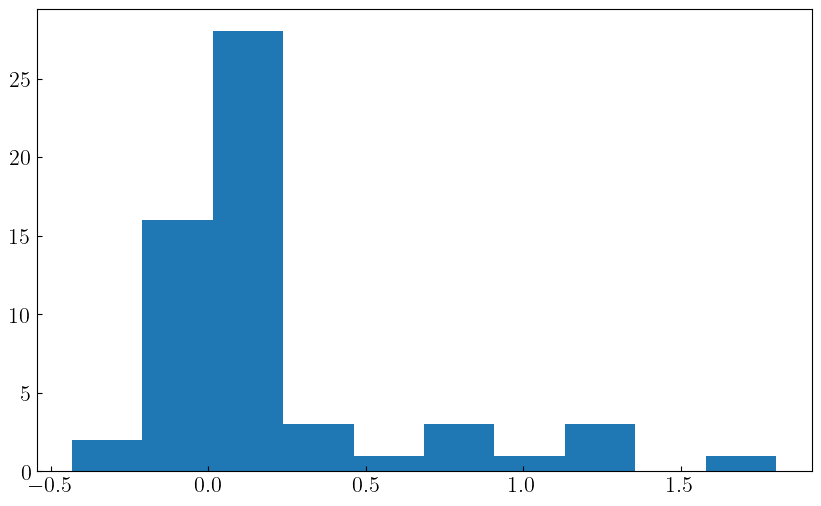

logfsr_ratios4


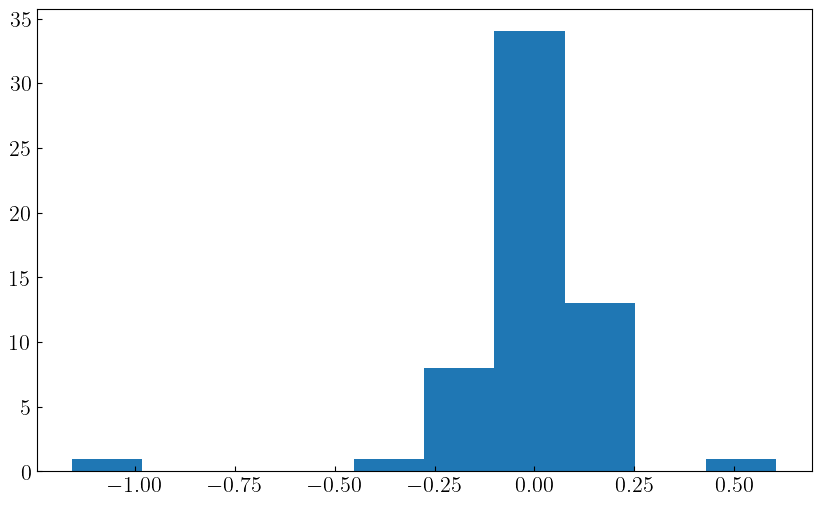

dust_index


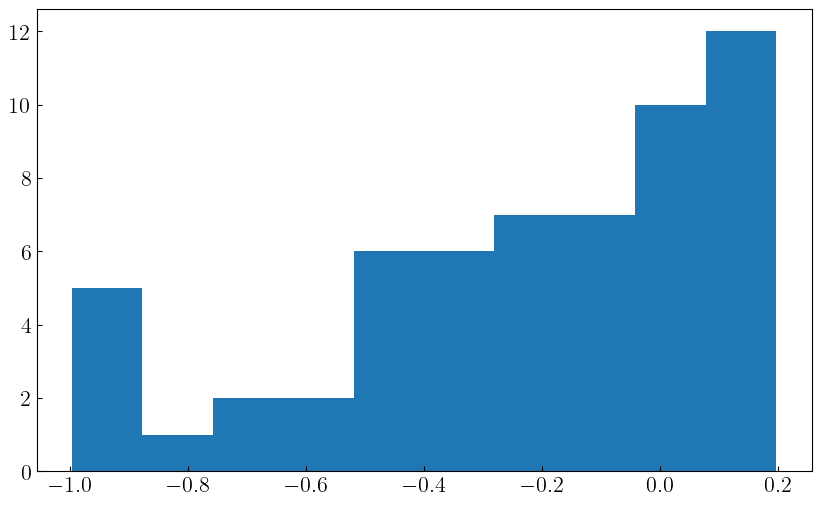

dust1_fraction


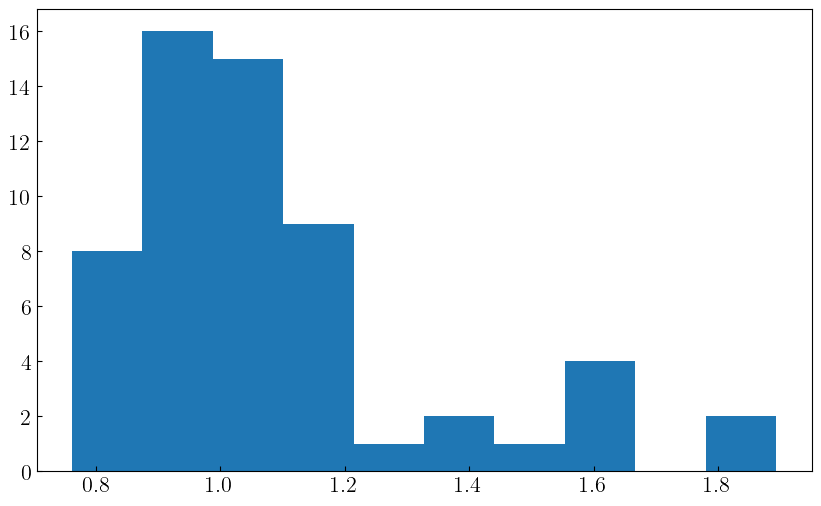

In [42]:
params_list = []
results_path = Path('PROSPECT_results')
for handle in [f for f in os.listdir(results_path) if 'local_3' in f]:
    out, out_obs,out_model = reader.results_from(str(results_path / handle))
    params_list.append(out['bestfit']['parameter'])
logzsol, dust2, logmass, logfsr_ratios1, logfsr_ratios2, logfsr_ratios3, logfsr_ratios4, dust_index, dust1_fraction = zip(*params_list)

param_names = ["logzsol", "dust2", "logmass", "logfsr_ratios1", "logfsr_ratios2", "logfsr_ratios3", "logfsr_ratios4", "dust_index", "dust1_fraction"]
for param, name in zip(zip(*params_list),param_names):
    print(name)
    plt.hist(param)
    plt.show()

### Local 4

logzsol


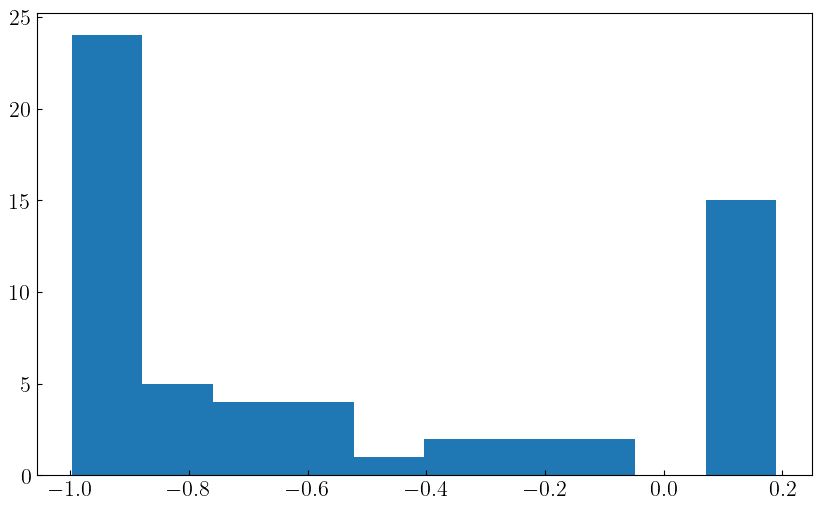

dust2


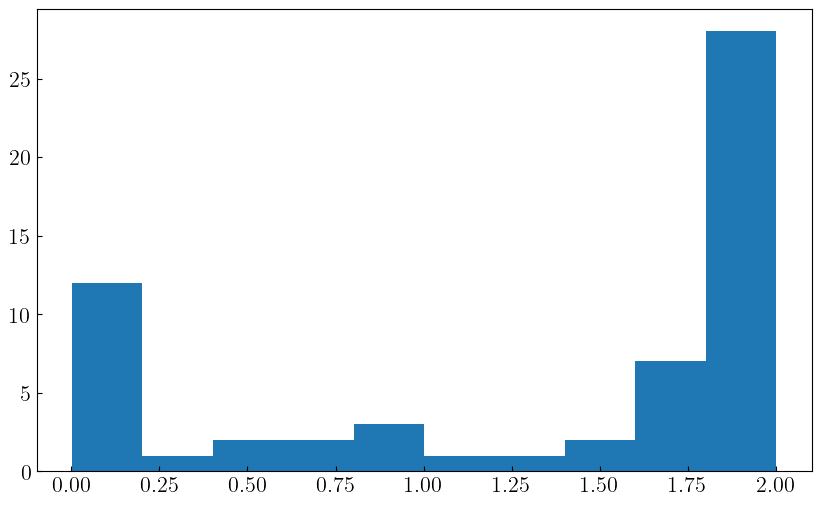

logmass


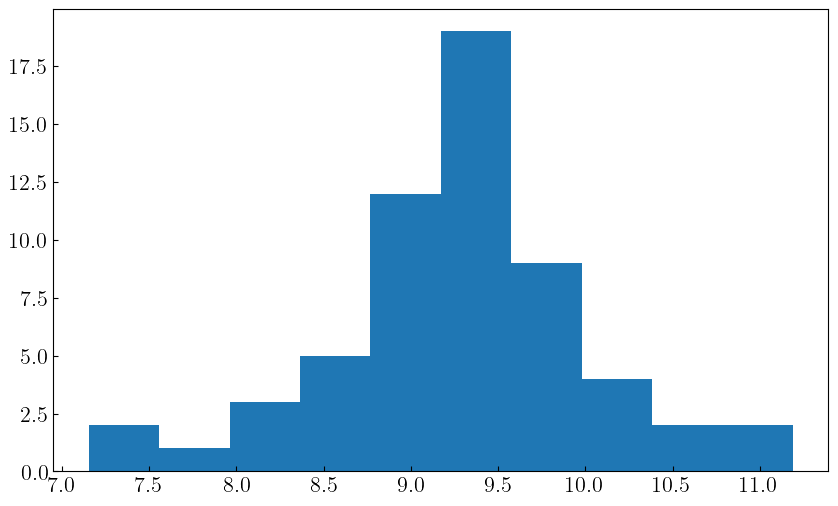

logfsr_ratios1


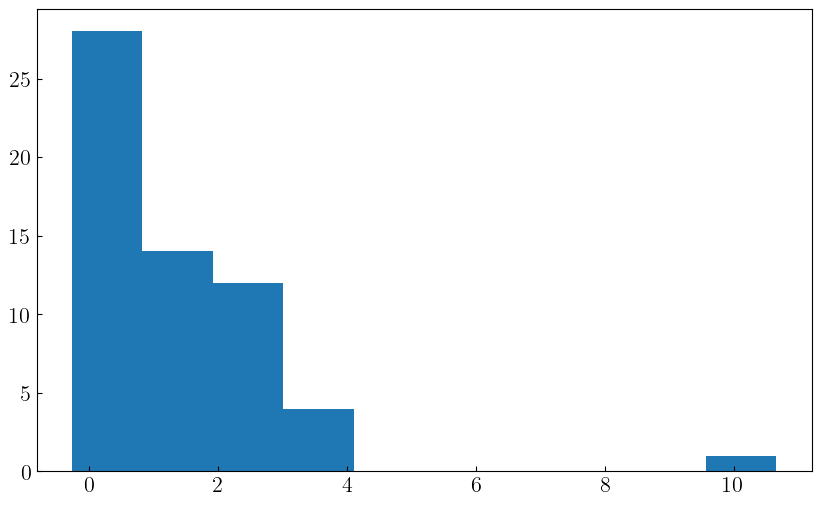

logfsr_ratios2


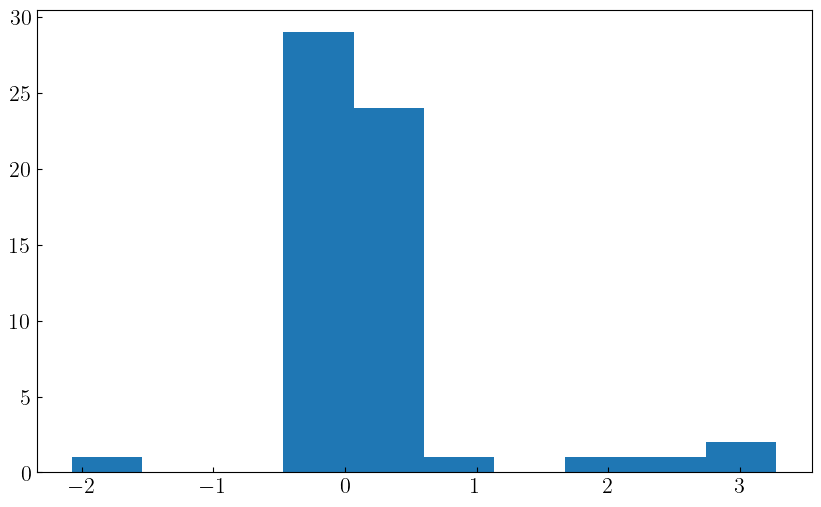

logfsr_ratios3


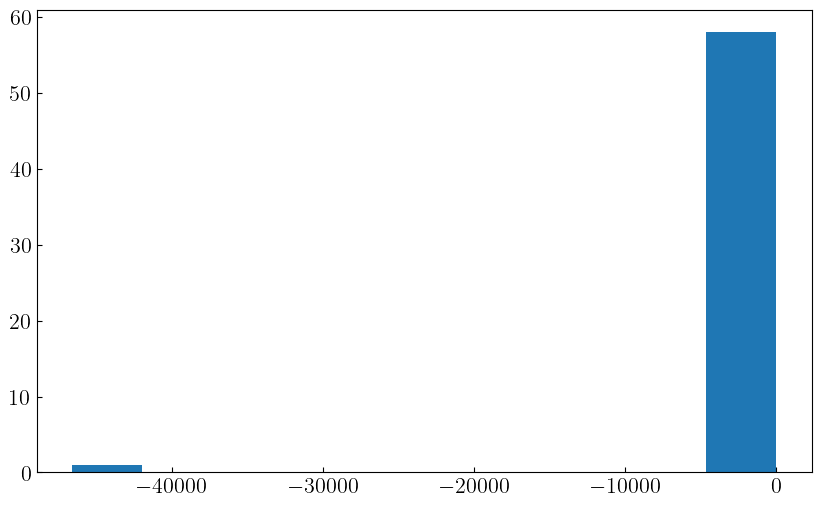

logfsr_ratios4


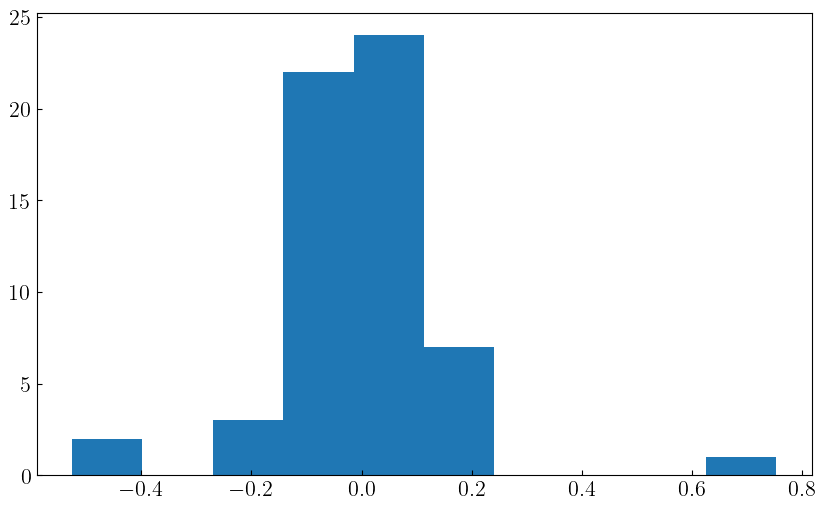

dust_index


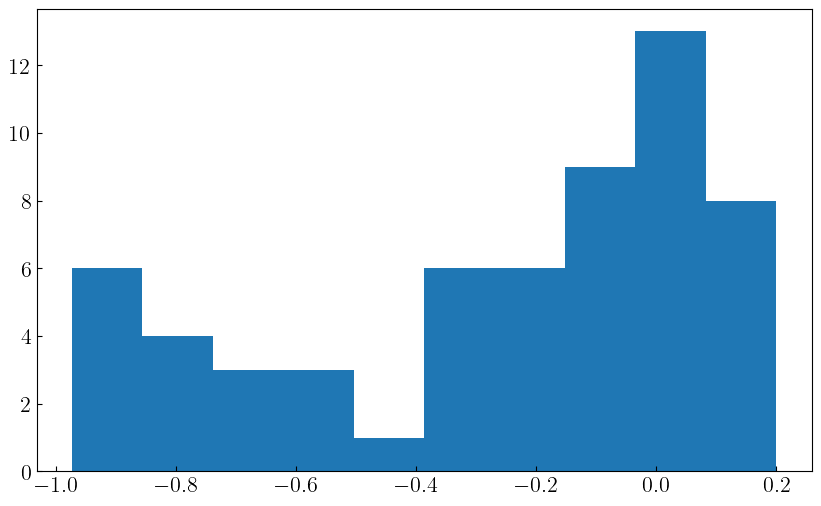

dust1_fraction


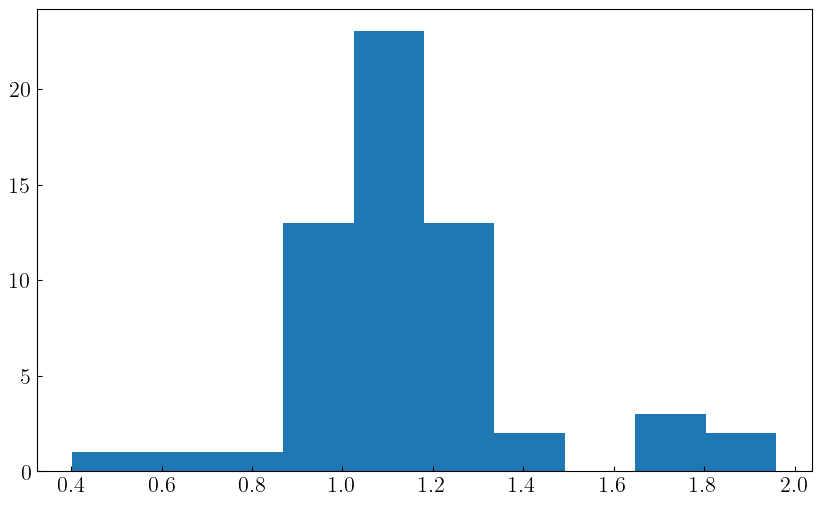

In [43]:
params_list = []
results_path = Path('PROSPECT_results')
for handle in [f for f in os.listdir(results_path) if 'local_4' in f]:
    out, out_obs,out_model = reader.results_from(str(results_path / handle))
    params_list.append(out['bestfit']['parameter'])
logzsol, dust2, logmass, logfsr_ratios1, logfsr_ratios2, logfsr_ratios3, logfsr_ratios4, dust_index, dust1_fraction = zip(*params_list)

param_names = ["logzsol", "dust2", "logmass", "logfsr_ratios1", "logfsr_ratios2", "logfsr_ratios3", "logfsr_ratios4", "dust_index", "dust1_fraction"]
for param, name in zip(zip(*params_list),param_names):
    print(name)
    plt.hist(param)
    plt.show()